Nasledujúce dve bunky slúžia na importovanie knižníc.

In [1]:
! apt install libgraphviz-dev
! pip install geoplot pyvis pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
from collections import Counter
from IPython.display import display, HTML
import plotly.express as px
import os

Vytvorili sme tabuľku table_taxonomy, ktorá obsahuje informácie o roztriedení jednotlivých druhov do taxonomických jednotiek.

In [3]:
species = pd.Series(['Human', 'Olive baboon', 'House mouse', 'Domestic dog', 'Bovine, Hereford cattle', 'Gray short-tailed opossum'])
latin = pd.Series(['Homo sapiens', 'Papio anubis', 'Mus musculus', 'Canis lupus familiaris', 'Bos taurus', 'Monodelphis domestica'])
class_tax = pd.Series(['Mammalia']*6)
clade = pd.Series(['Boreoeutheria', 'Boreoeutheria', 'Boreoeutheria', 'Boreoeutheria', 'Boreoeutheria', 'Ameridelphia'])
order = pd.Series(['Primates', 'Primates', 'Rodentia', 'Carnivora', 'Artiodactyla', 'Didelphimorphia'])
subdivision = pd.Series(['Euarchontoglires', 'Euarchontoglires', 'Euarchontoglires', 'Laurasiatheria', 'Laurasiatheria', 'Phalangeriformes'])

table_taxonomy = pd.DataFrame({'species':species,
                               'latin':latin,
                               'taxonomy_class':class_tax,
                               'clade':clade,
                               'order':order,
                               'sub class':subdivision}).set_index(['taxonomy_class', 'clade', 'sub class', 'order', 'species'])

display(table_taxonomy)

latin
taxonomy_class clade         sub class        order           species                                          
Mammalia       Boreoeutheria Euarchontoglires Primates        Human                                Homo sapiens
                                                              Olive baboon                         Papio anubis
                                              Rodentia        House mouse                          Mus musculus
                             Laurasiatheria   Carnivora       Domestic dog               Canis lupus familiaris
                                              Artiodactyla    Bovine, Hereford cattle                Bos taurus
               Ameridelphia  Phalangeriformes Didelphimorphia Gray short-tailed opossum   Monodelphis domestica

Na základe tabuľky table_taxonomy sme vytvorili stromový graf pre lepšiu vizualizáciu.

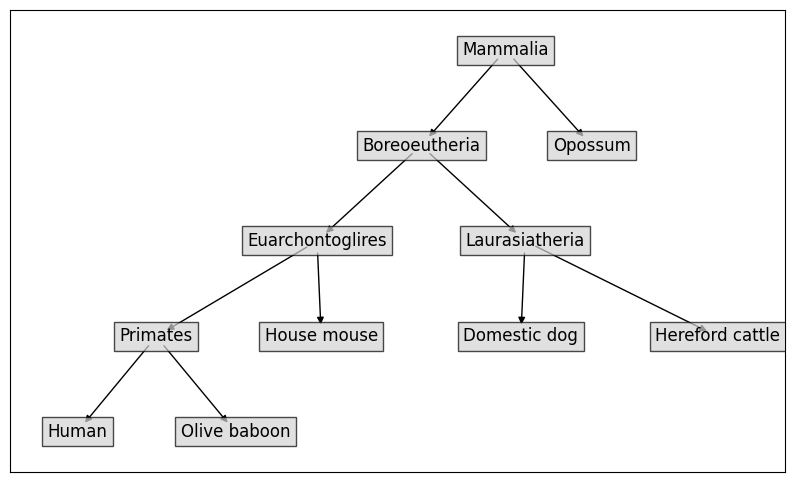

In [4]:
G = nx.DiGraph()
table = table_taxonomy.drop('latin', axis = 1)
for (taxonomy_class, clade, sub_class, order, species) in table.index:
  if species == 'Gray short-tailed opossum':
    species = 'Opossum'
  if species == 'Bovine, Hereford cattle':
    species = 'Hereford cattle'
  G.add_edge(taxonomy_class, clade, shape='square')
  G.add_edge(clade, sub_class)
  G.add_edge(sub_class, order)
  G.add_edge(order, species)
G.add_edge('Laurasiatheria', 'Domestic dog')
G.add_edge('Laurasiatheria', 'Hereford cattle')
G.add_edge('Euarchontoglires', 'House mouse')
G.add_edge('Mammalia', 'Opossum')
node_list = list(G.nodes())
for node in node_list:
  if node in ['Rodentia', 'Artiodactyla', 'Didelphimorphia', 'Carnivora', 'Phalangeriformes', 'Ameridelphia']:
    G.remove_node(node)
(figure, axes) = plt.subplots(figsize=(10, 6))
coordinates = nx.nx_agraph.graphviz_layout(G, prog="dot")
label_options = {"ec": "black", "fc": 'lightgray', "alpha": 0.7}
nx.draw_networkx_edges(G, coordinates, ax=axes)
nx.draw_networkx_labels(G, coordinates, font_size=12, bbox=label_options, ax=axes)
os.makedirs("img", exist_ok=True)
figure.savefig("img/taxonomy_tree.png", bbox_inches='tight')

V nasledujúcej bunke vytvárame tabuľku dist. V jej riadkoch sa nachádzajú ID všetkých proteínov. Každý stĺpec obsahuje dvojicu druhov a informáciu o tom, ako veľmi sa daný proteín odlišuje medzi týmito dvomi živočíchmi. Čím je hodnota nižšia, tým viac je daný proteín podobný medzi druhmi z dvojice.

In [5]:
url = "https://raw.githubusercontent.com/pilatova/prot-viz-data/test/dist2.tsv"

dist = pd.read_csv(
    url,
    sep='\t',           # Tab separator for TSV files
    header=0,           # Use the first row as headers
    index_col=0         # Set the first column ("protein_id") as the index
)

display(dist)

human-baboon  human-cow  human-dog  human-mouse  human-opossum  \
protein_id                                                                   
A0A087WTH1      0.029031   0.154998   0.110481     0.196955       0.344118   
A0A087WZ39      0.103670   0.377518   0.391924     0.578767       0.941801   
A0A096LP49      0.160867   0.640212   0.633581     0.685461       2.314668   
A0A0U1RRA0      0.016778   0.143482   0.109374     0.167911       0.544500   
A0A126GWI2      0.061848   0.209570   0.176613     0.199606       0.276475   
...                  ...        ...        ...          ...            ...   
Q9Y6Y8          0.020182   0.097383   0.087803     0.145415       0.200164   
Q9Y6Y9          0.078279   0.493353   0.340358     0.497160       0.827787   
Q9Y6Z7          0.011360   0.070712   0.066309     0.125549       0.252660   
W5XKT8          0.029052   0.302585   0.378708     0.507148       1.447436   
X6R8D5          0.085471   0.180538   0.296900     0.386710       0.903857   

            baboon-cow  baboon-dog  baboon-mouse  baboon-opossum   cow-dog  \
protein_id                                                                   
A0A087WTH1    0.144013    0.109375      0.232052        0.385447  0.138486   
A0A087WZ39    0.453725    0.498146      0.613333        1.076725  0.406620   
A0A096LP49    0.667860    0.642229      0.718148        2.226590  0.552318   
A0A0U1RRA0    0.162434    0.128345      0.148527        0.536199  0.088828   
A0A126GWI2    0.206727    0.171825      0.195499        0.269331  0.161940   
...                ...         ...           ...             ...       ...   
Q9Y6Y8        0.092122    0.083755      0.143263        0.199263  0.072680   
Q9Y6Y9        0.468792    0.350418      0.504158        0.774873  0.306680   
Q9Y6Z7        0.070417    0.066584      0.129581        0.242320  0.054214   
W5XKT8        0.303361    0.383292      0.504754        1.487102  0.391163   
X6R8D5        0.169504    0.260243      0.326888        0.817143  0.189159   

            cow-mouse  cow-opossum  dog-mouse  dog-opossum  mouse-opossum  
protein_id                                                                 
A0A087WTH1   0.217262     0.389459   0.192162     0.368851       0.437878  
A0A087WZ39   0.474470     0.844741   0.525629     0.926316       1.071503  
A0A096LP49   0.822833     2.328829   0.775940     2.277628       2.473843  
A0A0U1RRA0   0.183459     0.661912   0.089641     0.556196       0.551611  
A0A126GWI2   0.212899     0.259762   0.185132     0.232008       0.252956  
...               ...          ...        ...          ...            ...  
Q9Y6Y8       0.137832     0.189800   0.135092     0.196943       0.242393  
Q9Y6Y9       0.520962     0.909269   0.459060     0.850035       0.937334  
Q9Y6Z7       0.143420     0.219843   0.142122     0.222810       0.280857  
W5XKT8       0.550227     1.606456   0.643764     1.604940       1.416806  
X6R8D5       0.268994     0.796872   0.353637     0.841051       0.931670  

[13021 rows x 15 columns]

Na začiatku sme zrealizovali niekoľko základných analýz tabuľky dist.

In [6]:
# 1. Check for missing values
print("Missing values per column:")
display(dist.isnull().sum())

# 2. Check data types
print("\nData types:")
display(dist.dtypes)

# 3. Check numeric ranges (all values should be ≥0)
print("\nValue ranges:")
display(dist.describe())

# 4. Check for negative values (invalid for evolutionary distances)
negative_values = (dist < 0).any().any()
print(f"\nNegative values present? {negative_values}")
print(f"\nRows containing negative values:")
display(dist[(dist < 0).any(axis=1)])

# 5. Check index uniqueness (protein IDs should be unique)
print(f"\nUnique protein IDs? {dist.index.is_unique}")

# 6. Check row/column counts
print(f"\nData shape: {dist.shape} (rows x columns)")

# Check for unreasonably large distances (e.g., >10)
max_value = dist.max().max()
print(f"Maximum distance value: {max_value}")

# Check for zeros (if they should not exist between species)
zero_values = (dist == 0).any().any()
print(f"Zero values present? {zero_values}")

print(f"\nDrop row with negative value:")
dist.drop(dist[(dist < 0).any(axis=1)].index, inplace=True)
display(dist[(dist < 0).any(axis=1)])

Missing values per column:


human-baboon      0
human-cow         0
human-dog         0
human-mouse       0
human-opossum     0
baboon-cow        0
baboon-dog        0
baboon-mouse      0
baboon-opossum    0
cow-dog           0
cow-mouse         0
cow-opossum       0
dog-mouse         0
dog-opossum       0
mouse-opossum     0
dtype: int64


Data types:


human-baboon      float64
human-cow         float64
human-dog         float64
human-mouse       float64
human-opossum     float64
baboon-cow        float64
baboon-dog        float64
baboon-mouse      float64
baboon-opossum    float64
cow-dog           float64
cow-mouse         float64
cow-opossum       float64
dog-mouse         float64
dog-opossum       float64
mouse-opossum     float64
dtype: object


Value ranges:


human-baboon     human-cow     human-dog   human-mouse  human-opossum  \
count  13021.000000  13021.000000  13021.000000  13021.000000   13021.000000   
mean       0.038382      0.129694      0.123894      0.157894       0.285598   
std        0.069838      0.129373      0.126826      0.151289       0.255533   
min        0.000010      0.000010      0.000010      0.000010       0.000010   
25%        0.007703      0.039579      0.035248      0.050342       0.106073   
50%        0.021102      0.093793      0.086754      0.115105       0.217207   
75%        0.044141      0.178643      0.170895      0.216196       0.388580   
max        1.797991      2.155932      1.328868      1.683248       2.782719   

         baboon-cow    baboon-dog  baboon-mouse  baboon-opossum       cow-dog  \
count  13021.000000  13021.000000  13021.000000    13021.000000  13021.000000   
mean       0.141570      0.136912      0.169103        0.298921      0.128231   
std        0.147768      0.145471      0.165949        0.270132      0.137583   
min        0.000010      0.000010      0.000010        0.000010      0.000010   
25%        0.042359      0.038080      0.053805        0.110401      0.036623   
50%        0.100132      0.094019      0.123021        0.226567      0.089095   
75%        0.191181      0.185440      0.230195        0.404650      0.173883   
max        2.441345      2.040214      3.030621        3.452648      2.477352   

          cow-mouse   cow-opossum     dog-mouse   dog-opossum  mouse-opossum  
count  13021.000000  13021.000000  13021.000000  13021.000000   13021.000000  
mean       0.181213      0.299111      0.177729      0.298082       0.317772  
std        0.175140      0.270242      0.171626      0.269467       0.283351  
min        0.000010      0.000010      0.000010     -1.000000       0.000010  
25%        0.060014      0.112332      0.057303      0.109874       0.119185  
50%        0.132659      0.226829      0.128338      0.225141       0.240641  
75%        0.246104      0.404839      0.243410      0.403087       0.428674  
max        2.735270      3.005446      1.830683      3.079467       3.075986


Negative values present? True

Rows containing negative values:


human-baboon  human-cow  human-dog  human-mouse  human-opossum  \
protein_id                                                                   
Q8IYW2          0.189938   0.426894   0.205668     0.475243       0.675513   

            baboon-cow  baboon-dog  baboon-mouse  baboon-opossum   cow-dog  \
protein_id                                                                   
Q8IYW2        0.743782    0.190153      0.451264        1.776299  0.451167   

            cow-mouse  cow-opossum  dog-mouse  dog-opossum  mouse-opossum  
protein_id                                                                 
Q8IYW2       0.529828     0.739962   0.263684         -1.0       0.727156


Unique protein IDs? True

Data shape: (13021, 15) (rows x columns)
Maximum distance value: 3.452648
Zero values present? False

Drop row with negative value:


Empty DataFrame
Columns: [human-baboon, human-cow, human-dog, human-mouse, human-opossum, baboon-cow, baboon-dog, baboon-mouse, baboon-opossum, cow-dog, cow-mouse, cow-opossum, dog-mouse, dog-opossum, mouse-opossum]
Index: []

In [7]:
dist.to_csv('dist3.tsv', sep = '\t', encoding='utf-8', index=True)

V ďalšej bunke zisťujeme, ako veľmi sa jednotlivé druhy líšia od človeka (percentuálne). Vizualizujeme to pomocou barplotu.

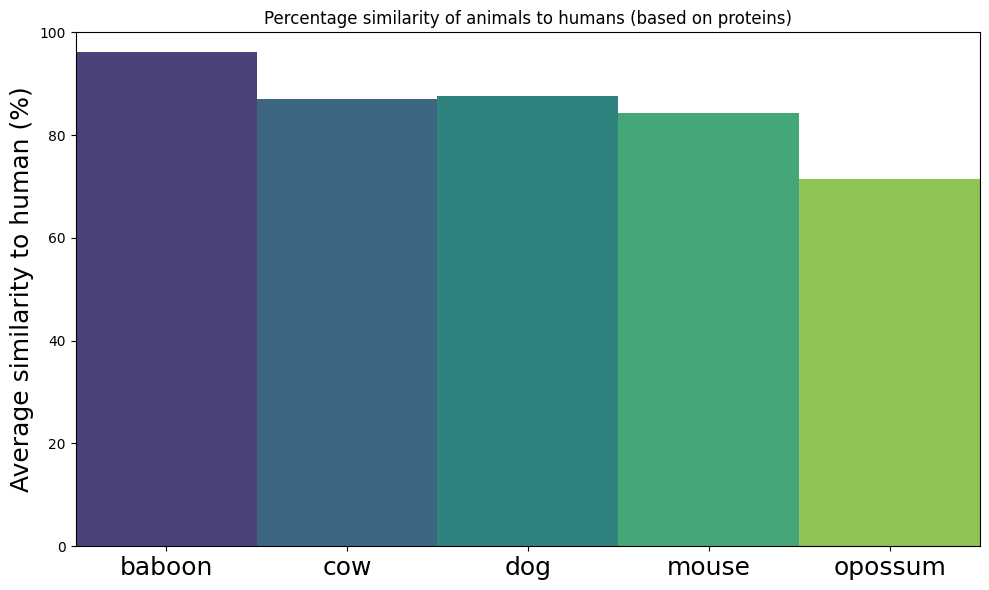

Najpodobnejšie zviera človeku je: baboon (96.16 %)


In [8]:
# graf: podobnost cloveka k zvieratam
human_df = dist.iloc[:, :5]
avg = human_df.mean()
similarity = (1 - avg) * 100
similarity.index = similarity.index.str.replace('human-', '')

# vykreslenie grafu
plot_df = similarity.reset_index()
plot_df.columns = ['Animal', 'Similarity (%)']
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x='Animal', y='Similarity (%)', hue='Animal', palette='viridis', width = 1, dodge=False, legend=False)
plt.ylabel('Average similarity to human (%)', fontsize=18)
plt.xlabel('')
plt.title('Percentage similarity of animals to humans (based on proteins)')
plt.ylim(0, 100)
plt.xticks(fontsize=18)
plt.tight_layout()
plt.show()

# print vysledku
print(f'Najpodobnejšie zviera človeku je: {similarity.idxmax()} ({similarity[similarity.idxmax()]:.2f} %)')

Vytvorili sme tabuľku species_human, ktorá obsahuje iba tie stĺpce dabuľky dist, v ktorých sa porovnáva človek k inému druhu.

In [9]:
columns = ['human-baboon', 'human-cow', 'human-dog', 'human-mouse', 'human-opossum']
species_human = dist.loc[:, columns]

# tabulka species_human obsahuje vzdialenosti vsetkych 13 021 proteinov a vzdialenosti medzi clovekom a ostatnymi druhmi
display(species_human)

human-baboon  human-cow  human-dog  human-mouse  human-opossum
protein_id                                                                
A0A087WTH1      0.029031   0.154998   0.110481     0.196955       0.344118
A0A087WZ39      0.103670   0.377518   0.391924     0.578767       0.941801
A0A096LP49      0.160867   0.640212   0.633581     0.685461       2.314668
A0A0U1RRA0      0.016778   0.143482   0.109374     0.167911       0.544500
A0A126GWI2      0.061848   0.209570   0.176613     0.199606       0.276475
...                  ...        ...        ...          ...            ...
Q9Y6Y8          0.020182   0.097383   0.087803     0.145415       0.200164
Q9Y6Y9          0.078279   0.493353   0.340358     0.497160       0.827787
Q9Y6Z7          0.011360   0.070712   0.066309     0.125549       0.252660
W5XKT8          0.029052   0.302585   0.378708     0.507148       1.447436
X6R8D5          0.085471   0.180538   0.296900     0.386710       0.903857

[13020 rows x 5 columns]

Pomocou umelej inteligencie (Chat GPT) sme vytvorili tabuľku selected_species_human, ktorá obsahuje 30 proteínov, ktoré sú medzi všetkými dvojicami druhov najmenej podobné.

In [10]:
# tuto cast vytvoril ChatGPT, vybera sa 30 proteinov, ktore maju v riadku najviac odlisne hodnoty (aby sme v grafe videli rozdiely)
variability = species_human.max(axis=1) - species_human.min(axis=1)
top_20_proteins = variability.nlargest(30).index
selected_species_human = species_human.loc[top_20_proteins]
display(selected_species_human)

human-baboon  human-cow  human-dog  human-mouse  human-opossum
protein_id                                                                
Q8N5Q1          0.136316   0.806504   0.691520     0.842278       2.782719
Q6ZQX7          0.215995   0.443016   0.358501     0.483241       2.432181
A0A096LP49      0.160867   0.640212   0.633581     0.685461       2.314668
Q15392          0.006094   0.033027   0.032885     0.032884       2.122706
Q96HA4          0.058036   2.155932   0.846373     0.350358       0.681627
Q8NCD3          0.147984   0.634312   0.669399     0.863560       2.114177
Q09MP3          0.091726   0.460967   0.614156     0.648497       1.930901
Q9Y6A2          0.004157   0.075996   0.061085     0.055175       1.811112
Q9HBB8          0.092548   0.493553   0.462941     0.508528       1.866036
Q6JVE9          0.120562   0.682338   0.499876     0.584549       1.863223
Q9NU63          0.103566   0.549771   0.758327     0.997794       1.845846
Q9NZV5          0.148508   1.811946   0.201791     0.114828       0.258047
Q05C16          0.099765   0.536150   0.509196     0.693708       1.788381
Q8N2Z9          0.014091   0.183372   0.274335     0.337404       1.694236
Q8NAG6          0.233170   0.351876   0.577928     0.536918       1.899993
P46013          0.114429   0.818714   0.741472     0.877639       1.762900
Q9UBD9          0.009559   0.038603   0.023998     0.033708       1.654214
Q8TC71          0.047419   0.177190   0.366489     0.309488       1.685502
Q5JVX7          0.088002   0.583954   0.461139     1.041687       1.721776
P03973          0.115887   0.538415   0.544463     0.670429       1.747396
Q8TCU4          0.087176   0.358467   0.485348     0.520167       1.692590
P56715          0.058851   0.362325   0.314909     0.490517       1.661522
Q14093          0.126721   0.477778   0.639445     0.752446       1.714656
Q8TAL5          0.095448   0.530410   0.582784     0.935089       1.673969
Q5JXA9          0.063577   0.323535   0.395758     1.428071       1.639521
Q0VD83          0.108086   0.540526   0.579706     0.786009       1.674330
Q96SL8          0.032623   0.083608   0.087955     0.145276       1.579529
Q8N0W7          0.280900   0.971535   0.829938     1.138263       1.825569
O43824          1.797991   0.269910   0.277036     0.479737       0.366319
Q9H0B3          0.112626   0.650038   0.581735     0.738408       1.635355

Na základe predošlých dát sme vytvorili interaktívny scatter plot.

In [11]:
# vytvorila som novu tabulku df_long, ktora v ktorej som rozdelila stlpce tvaru human-nieco na stlpec human a stlpec nieco
df_long = selected_species_human.reset_index().melt(
    id_vars='protein_id',
    var_name='species_pair',
    value_name='distance'
)

df_long[['species1', 'species2']] = df_long['species_pair'].str.split('-', expand=True)

mean_distance = df_long['distance'].mean()

df_long['x'] = df_long['protein_id']
df_long['y'] = df_long['species2']

df_long['normalized_distance'] = (df_long['distance'] - 0) / (3.0 - 0)

fig = px.scatter(
    df_long,
    x='x',
    y='y',
    color='normalized_distance',
    color_continuous_scale=[[0, 'green'], [0.5, 'yellow'], [1.0, 'red']],
    range_color=(0, 1),
    hover_data={'protein_id': True, 'distance': True, 'y': False, 'x': False}
)

fig.update_traces(marker=dict(size=18))

fig.update_layout(
    plot_bgcolor='white',
    title='Protein distance across species (relative to human)',
    title_x=0.5,
    xaxis_title='Protein ID',
    yaxis_title='',
    yaxis_tickfont=dict(size=22),
    xaxis_title_font=dict(size=25),
    width=1400,
    height=500
)
fig.show()

V nasledujúcich bunkách počítame rýchlosť mutácií proteínov a vizualizujeme ich v grafoch.

In [12]:
# weights (median time) sourced from https://timetree.org/
weights = {
    'human-baboon': 28.8,
    'human-cow': 94,
    'human-dog': 94,
    'human-mouse': 87,
    'human-opossum': 160,
    'baboon-cow': 94,
    'baboon-dog': 94,
    'baboon-mouse': 87,
    'baboon-opossum': 160,
    'cow-dog': 76,
    'cow-mouse': 94,
    'cow-opossum': 160,
    'dog-mouse': 94,
    'dog-opossum': 160,
    'mouse-opossum': 160
}

distance_cols = dist.columns[:]
weight_values = [weights[col] for col in distance_cols]
normalized = dist[distance_cols].div(weight_values)

means = dist.mean(axis=1)
medians = dist.median(axis=1)
human_means = dist.iloc[:, :5].mean(axis=1)
human_medians = dist.iloc[:, :5].median(axis=1)
normalized_means = normalized.mean(axis=1)

metrics = {
    'means': means,
    'medians': medians,
    'human_means': human_means,
    'human_medians': human_medians,
    'normalized_means': normalized_means,
}

print("Metric Summary Statistics:")
for name, values in metrics.items():
    print(f"\n{name.replace('_', ' ').title()}:")
    print(values.describe())

Metric Summary Statistics:

Means:
count    13020.000000
mean         0.192253
std          0.167451
min          0.000010
25%          0.071562
50%          0.147489
75%          0.262727
max          1.791390
dtype: float64

Medians:
count    13020.000000
mean         0.170570
std          0.156422
min          0.000010
25%          0.057841
50%          0.127014
75%          0.234768
max          1.627089
dtype: float64

Human Means:
count    13020.000000
mean         0.147073
std          0.129818
min          0.000010
25%          0.052882
50%          0.112667
75%          0.201493
max          1.288477
dtype: float64

Human Medians:
count    13020.000000
mean         0.129885
std          0.124131
min          0.000010
25%          0.040484
50%          0.095262
75%          0.181033
max          1.368631
dtype: float64

Normalized Means:
count    1.302000e+04
mean     1.708402e-03
std      1.508224e-03
min      1.106323e-07
25%      6.176858e-04
50%      1.309042e-03
75%      2

<Axes: xlabel='value', ylabel='Count'>

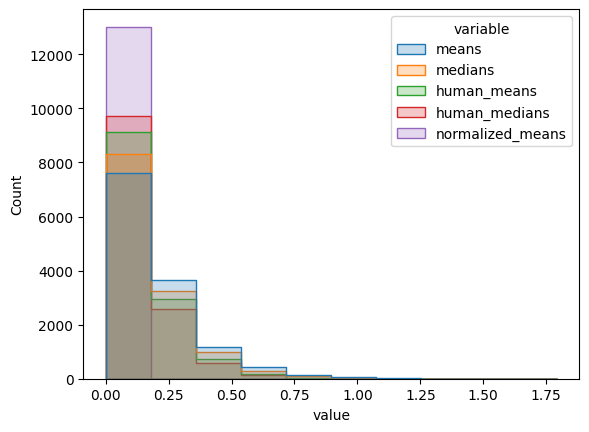

In [13]:
xy = pd.DataFrame(metrics)
xyz = xy.reset_index().drop(columns=['protein_id'])
ab = xyz.melt()

bins = [x/100 for x in range(0, 76, 2)]
sns.histplot(data=ab, x='value', hue='variable', bins=10, element='step')

<Axes: xlabel='value', ylabel='Probability'>

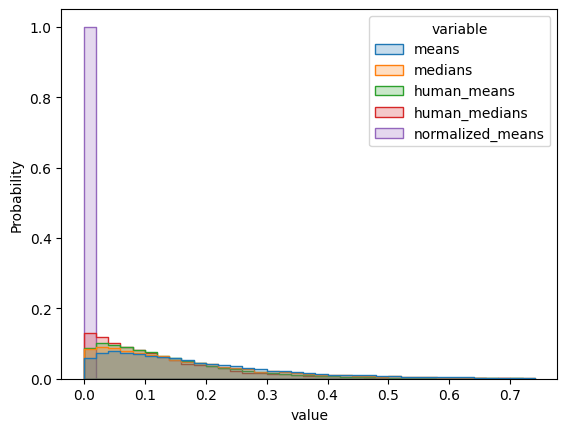

In [14]:
sns.histplot(data=ab, x='value', hue='variable', bins=bins, element='step', stat='probability', common_norm=False)

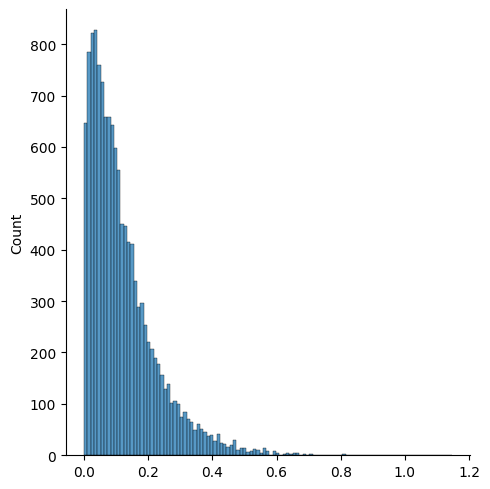

In [15]:
mean_mean = xy[['means', 'medians', 'normalized_means']].mean(axis=1)
sns.displot(mean_mean)

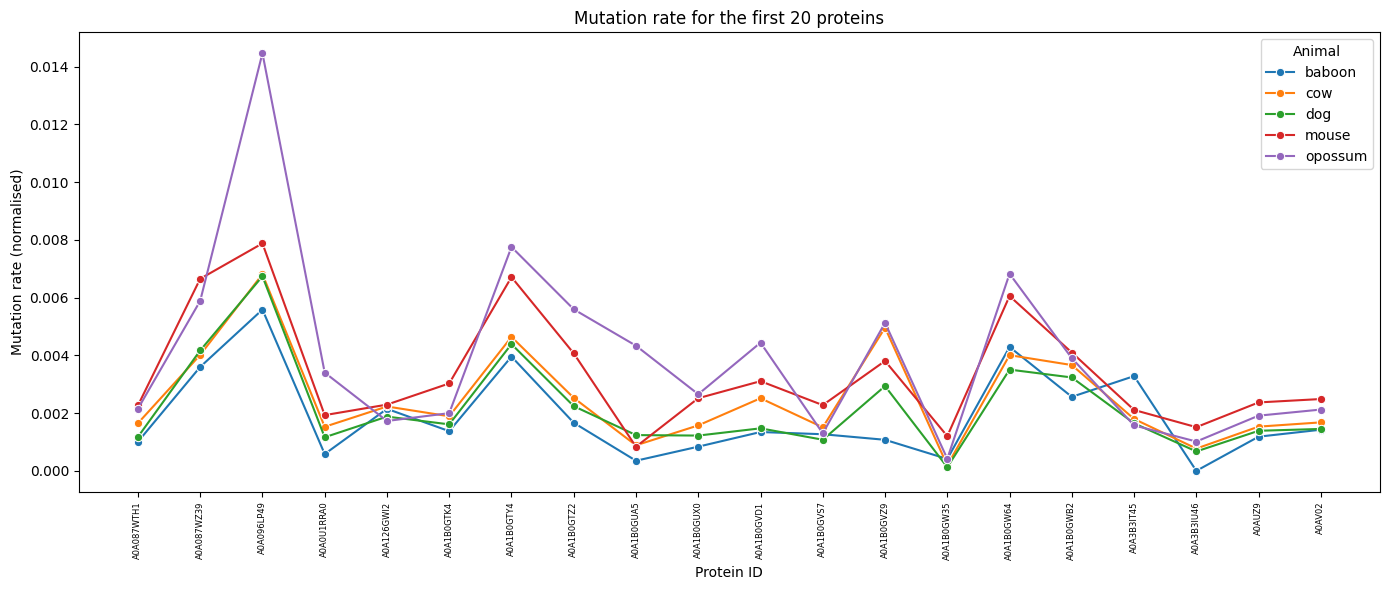

In [16]:
# nastavenia
top_n = 20
animals = ['human-baboon', 'human-cow', 'human-dog', 'human-mouse', 'human-opossum']

# priprava dat
subset = normalized.iloc[:top_n][animals].copy()
subset['protein_id'] = subset.index
long_df = subset.melt(id_vars='protein_id', var_name='Animal', value_name='speed_of_mutation')
long_df['Animal'] = long_df['Animal'].str.replace('human-', '', regex=False)

# graf:
plt.figure(figsize=(14, 6))
sns.lineplot(data=long_df, x='protein_id', y='speed_of_mutation', hue='Animal', marker='o')
plt.xticks(rotation=90, fontsize=6)
plt.title(f'Mutation rate for the first {top_n} proteins')
plt.ylabel('Mutation rate (normalised)')
plt.xlabel('Protein ID')
plt.legend(title='Animal')
plt.tight_layout()
plt.show()

V nasledujúcej bunke sme vytvorili scatter plot fig, ktorý zobrazuje rýchlosť mutovania proteínov podľa priemernov zaokrúhlených hodnôt v riadkoch tabuľky dist.

In [17]:
# calculate average and rounded average
dist2 = dist
dist2['avg'] = dist.mean(axis=1)
dist2['avg_rounded'] = dist['avg'].round(2)
dist2_reset = dist2.reset_index()

# group by average and take only the first id for each unique value
grouping = dist2_reset.groupby('avg_rounded').agg({
    'protein_id': lambda x: list(x),
    'avg': 'first'
}).reset_index()

# tu som si pomohol chatom pretoze prvych proteinov je vela a nie je ich vidno na grafe
# ak niekto vie ako na to tak kludne nech to zmeni
# ale zase nemal to spravne a doupravoval som to ja cize 50/50 prace :D
def format_protein_list(protein_list):
    if len(protein_list) <= 5:
        return protein_list
    else:
        return ', '.join(protein_list[:5]) + f", +{len(protein_list) - 5}"

grouping['protein_id_display'] = grouping['protein_id'].apply(format_protein_list)

# prepare x and y for plotting
grouping['x'], grouping['y']= grouping['avg_rounded'], grouping['avg_rounded']

# plot
fig = px.scatter(
    grouping,
    x='x',
    y='y',
    hover_data={
        'x': False,
        'y': False,
        'avg_rounded': True,
        'protein_id_display': True
    },
    title='Protein dissimilarity mean'
)
fig.show()

Naším ďalším cieľom je zistiť, ktoré proteíny mutujú najviac a ktoré najmenej, respektíve ktoré proteíny sa najviac a ktoré sa najmenej líšia medzi jednotlivými druhmi. Nasledujúci kód vytvára tabuľky most_freq_lowest a most_freq_highest, ktoré obsahujú informácie o počte výskytov týchto proteínov.

In [18]:
melted = pd.DataFrame()
proteins = []
pairs = []
vals = []
for prot in dist.index:
  for pair in dist.columns:
    proteins.append(prot)
    pairs.append(pair)
    vals.append(dist.loc[prot, pair])
melted['protein_id'] = proteins
melted['value'] = vals
melted['pair'] = pairs
sorted = melted.sort_values('value')
sorted = sorted.query('value > 0')
lowest = sorted[:100].drop('pair', axis = 1)
lowest2 = sorted.query('value < 0.00002')
display(len(lowest2))
highest = sorted.tail(100).drop('pair', axis = 1)
#tabulka lowest vyberie prvych 100 riadkov tabulky dist, teda 100 najnizsich hodnot, to iste highest, len 100 najvyssich hodnot
most_freq_lowest = lowest.value_counts()
most_freq_lowest = most_freq_lowest.reset_index().set_index('protein_id')
most_freq_lowest = most_freq_lowest.query('count > 1')
highest = highest.set_index('protein_id')
#most_freq_lowest tabulka je tabulka, ktora pocita kolko krat sa dany protein nachadza v tabulke lowest, teda nam hovori ake proteiny maju medzi kolko parmi najmensie rozdiely
#tabulka lowest by sa dala robit z ovela viac ako prvych 100, kedze hodnot == 0,0001 je az len(lowest2), teda vyse 4000. Avsak vacsina z nich by mala count 1, cize myslim,
#ze analyzovat vsetkych 4000 ktore maju count 1 je zbytocne a staci sa nam zamerat na tie, ktore maju count aspon 2

display(most_freq_lowest)
#v highest sa nenachadzaju proteiny s rovnako vysokou hodnotou medzi viacerymi parmi, cize count je vzdy 1, takze most_frequent highest nerobim
most_freq_highest = highest.tail(len(most_freq_lowest))
display(most_freq_highest)

4600

value  count
protein_id                
P62380      0.00001     10
P60709      0.00001      6
P62495      0.00001      6
Q15843      0.00001      6
P62491      0.00001      5
P62487      0.00001      4
P62333      0.00001      4
Q4KMZ8      0.00001      4
Q9NRR3      0.00001      3
Q2NL67      0.00001      3
P62424      0.00001      3
P60891      0.00001      3
P23511      0.00001      3
O75204      0.00001      2
O15511      0.00001      2
Q13616      0.00001      2
P84085      0.00001      2
Q969W0      0.00001      2
P24844      0.00001      2

value
protein_id          
Q9NU63      2.382410
Q9NU63      2.399348
Q6ZQX7      2.432181
Q17RF5      2.441345
A0A096LP49  2.473843
Q53H47      2.477352
Q17RF5      2.516389
Q8N5Q1      2.568131
Q6ZQX7      2.599157
Q53H47      2.735270
Q6ZQX7      2.746796
Q8N5Q1      2.782719
Q8N5Q1      2.916768
Q8N5Q1      3.005446
P26951      3.030621
Q8N5Q1      3.042676
Q6ZQX7      3.075986
Q6ZQX7      3.079467
P26951      3.452648

Vytvorili sme tabuľku id, ktorá obsahuje protein_id a go_id všetkých proteínov.

In [19]:
url2 = "https://raw.githubusercontent.com/pilatova/prot-viz-data/refs/heads/main/goslim.tsv"
id = pd.read_csv(
    url2,
    sep='\t',
    header=0,
    index_col=0
)
display(id)

go_id
protein_id            
A0A087WZ39  GO:0005886
A0A087WZ39  GO:0023052
A0A096LP49  GO:0005815
A0A096LP49  GO:0005856
A0A096LP49  GO:0007010
...                ...
Q9Y6Z7      GO:0098772
W5XKT8      GO:0022414
W5XKT8      GO:0031410
W5XKT8      GO:0043226
W5XKT8      GO:0061024

[119792 rows x 1 columns]

Vytvorili sme tabuľku id, ktorá obsahuje go_id a funkciu všetkých proteínov.

In [20]:
url3 = "https://raw.githubusercontent.com/pilatova/prot-viz-data/refs/heads/main/goslim-names.tsv"
functions = pd.read_csv(
    url3,
    sep='\t',
    header=0,
    index_col=0
)
display(functions)

name
go_id                                                       
GO:0000228                                nuclear chromosome
GO:0000278                                mitotic cell cycle
GO:0000910                                       cytokinesis
GO:0001618                           virus receptor activity
GO:0002181                           cytoplasmic translation
...                                                      ...
GO:0140223  general transcription initiation factor activity
GO:0140299                         molecular sensor activity
GO:0140313                   molecular sequestering activity
GO:0140657                            ATP-dependent activity
GO:1901135         carbohydrate derivative metabolic process

[135 rows x 1 columns]

Snažili sme sa zistiť, aké funkcie majú najzaujímavejšie proteíny. Vytvorili sme funkciu most_interesting, ktorá vracia potrebnú tabuľku.

In [21]:
def most_interesting(table1, table2, column):
  info_list = []
  tab_reset = table1.reset_index()
  for protein in tab_reset[column]:
      info_list.append(protein)
  final_tab = table2.loc[table2.index.isin(info_list)]
  return final_tab

V nasledujúcej bunke voláme funkciu most_interesting a vytvárame tak 4 tabuľky, dve pre najviac mutujúce proteíny a dve pre najviac mutujúce proteíny.

In [22]:
lowest_protein_id_go_id = most_interesting(most_freq_lowest, id, 'protein_id')
lowest_go_id_name = most_interesting(lowest_protein_id_go_id, functions, 'go_id')
highest_protein_id_go_id = most_interesting(most_freq_highest, id, 'protein_id')
highest_go_id_name = most_interesting(highest_protein_id_go_id, functions, 'go_id')

display(lowest_protein_id_go_id)
display(lowest_go_id_name)
display(highest_protein_id_go_id)
display(highest_go_id_name)

go_id
protein_id            
O15511      GO:0005198
O15511      GO:0005576
O15511      GO:0005615
O15511      GO:0005634
O15511      GO:0005694
...                ...
Q9NRR3      GO:0016192
Q9NRR3      GO:0023052
Q9NRR3      GO:0043226
Q9NRR3      GO:0048856
Q9NRR3      GO:0060090

[217 rows x 1 columns]

name
go_id                                                       
GO:0000278                                mitotic cell cycle
GO:0000910                                       cytokinesis
GO:0002181                           cytoplasmic translation
GO:0002376                             immune system process
GO:0003012                             muscle system process
...                                                      ...
GO:0140098                 catalytic activity, acting on RNA
GO:0140110                  transcription regulator activity
GO:0140223  general transcription initiation factor activity
GO:0140657                            ATP-dependent activity
GO:1901135         carbohydrate derivative metabolic process

[70 rows x 1 columns]

go_id
protein_id            
A0A096LP49  GO:0005815
A0A096LP49  GO:0005856
A0A096LP49  GO:0007010
A0A096LP49  GO:0008092
A0A096LP49  GO:0043226
P26951      GO:0005886
P26951      GO:0023052
P26951      GO:0060089
P26951      GO:0023052
P26951      GO:0060089
Q17RF5      GO:0005576
Q17RF5      GO:0048856
Q53H47      GO:0000278
Q53H47      GO:0003677
Q53H47      GO:0003824
Q53H47      GO:0005634
Q53H47      GO:0005694
Q53H47      GO:0005730
Q53H47      GO:0006260
Q53H47      GO:0006281
Q53H47      GO:0006325
Q53H47      GO:0016740
Q53H47      GO:0016787
Q53H47      GO:0023052
Q53H47      GO:0036211
Q53H47      GO:0043226
Q53H47      GO:0140096
Q53H47      GO:0140097
Q6ZQX7      GO:0005634
Q6ZQX7      GO:0005730
Q6ZQX7      GO:0030163
Q6ZQX7      GO:0036211
Q6ZQX7      GO:0043226
Q6ZQX7      GO:0060090
Q9NU63      GO:0003677
Q9NU63      GO:0005634
Q9NU63      GO:0006351
Q9NU63      GO:0006355
Q9NU63      GO:0043226
Q9NU63      GO:0140110

name
go_id                                                
GO:0000278                         mitotic cell cycle
GO:0003677                                DNA binding
GO:0003824                         catalytic activity
GO:0005576                       extracellular region
GO:0005634                                    nucleus
GO:0005694                                 chromosome
GO:0005730                                  nucleolus
GO:0005815              microtubule organizing center
GO:0005856                               cytoskeleton
GO:0005886                            plasma membrane
GO:0006260                            DNA replication
GO:0006281                                 DNA repair
GO:0006325                     chromatin organization
GO:0006351                DNA-templated transcription
GO:0006355  regulation of DNA-templated transcription
GO:0007010                  cytoskeleton organization
GO:0008092               cytoskeletal protein binding
GO:0016740                       transferase activity
GO:0016787                         hydrolase activity
GO:0023052                                  signaling
GO:0030163                  protein catabolic process
GO:0036211               protein modification process
GO:0043226                                  organelle
GO:0048856           anatomical structure development
GO:0060089              molecular transducer activity
GO:0060090                 molecular adaptor activity
GO:0140096    catalytic activity, acting on a protein
GO:0140097          catalytic activity, acting on DNA
GO:0140110           transcription regulator activity

Vytvorili sme funkciu create_merged, ktorá prepája dve tabuľky do jednej cez go_id.

In [23]:
def create_merged(table1, table2):
  tab1_reset = table1.reset_index()
  tab2_reset = table2.reset_index()
  # spojenie tabuliek do jednej cez 'go_id'
  tab_merged = pd.merge(
      tab1_reset,
      tab2_reset,
      on='go_id',
      how='inner'
  )
  final_tab = tab_merged[['protein_id', 'name']].set_index(['protein_id', 'name'])
  return final_tab

V nasledujúcej bunke vytvárame výsledné tabuľky pre najviac a najmenej mutujúce proteíny pomocou funkcie create_merged.

In [24]:
tab_lowest_functions = create_merged(lowest_protein_id_go_id, lowest_go_id_name)
tab_highest_functions = create_merged(highest_protein_id_go_id, highest_go_id_name)

display(tab_lowest_functions)
display(tab_highest_functions)

Empty DataFrame
Columns: []
Index: [(O15511, structural molecule activity), (O15511, extracellular region), (O15511, extracellular space), (O15511, nucleus), (O15511, chromosome), (O15511, cytosol), (O15511, cytoskeleton), (O15511, cytoskeleton organization), (O15511, cytoskeletal protein binding), (O15511, cytoplasmic vesicle), (O15511, organelle), (O15511, cell motility), (O15511, protein-containing complex assembly), (O75204, endosome), (O75204, plasma membrane), (O75204, signaling), (O75204, cytoplasmic vesicle), (O75204, organelle), (P23511, DNA binding), (P23511, nucleus), (P23511, nucleoplasm), (P23511, chromosome), (P23511, DNA-templated transcription), (P23511, regulation of DNA-templated transcription), (P23511, protein modification process), (P23511, organelle), (P23511, transcription regulator activity), (P24844, muscle system process), (P24844, structural molecule activity), (P24844, cytosol), (P24844, cytoskeleton), (P24844, cytoskeleton organization), (P24844, cell adhesion), (P24844, cytoskeletal protein binding), (P24844, cell differentiation), (P24844, wound healing), (P24844, organelle), (P24844, anatomical structure development), (P60709, mitotic cell cycle), (P60709, immune system process), (P60709, DNA binding), (P60709, catalytic activity), (P60709, structural molecule activity), (P60709, extracellular region), (P60709, extracellular space), (P60709, nucleus), (P60709, nucleoplasm), (P60709, chromosome), (P60709, cytosol), (P60709, cytoskeleton), (P60709, plasma membrane), (P60709, DNA repair), (P60709, DNA recombination), (P60709, chromatin organization), (P60709, DNA-templated transcription), (P60709, regulation of DNA-templated transcription), (P60709, cytoskeleton organization), (P60709, chromosome segregation), (P60709, cell adhesion), (P60709, establishment or maintenance of cell polarity), (P60709, cytoskeletal protein binding), (P60709, programmed cell death), (P60709, vesicle-mediated transport), (P60709, hydrolase activity), (P60709, cell differentiation), (P60709, cell junction organization), (P60709, protein modification process), (P60709, wound healing), (P60709, organelle), (P60709, anatomical structure development), (P60709, cell motility), (P60709, transmembrane transport), (P60709, protein localization to plasma membrane), (P60891, catalytic activity), (P60891, cytosol), (P60891, transferase activity), (P60891, anatomical structure development), (P60891, nucleobase-containing small molecule metabolic process), (P60891, carbohydrate derivative metabolic process), (P62333, catalytic activity), (P62333, extracellular region), (P62333, extracellular space), (P62333, nucleus), (P62333, nucleoplasm), (P62333, cytosol), (P62333, DNA-templated transcription), (P62333, regulation of DNA-templated transcription), (P62333, hydrolase activity), (P62333, protein catabolic process), (P62333, organelle), (P62333, molecular adaptor activity), (P62333, protein-containing complex assembly), (P62333, ATP-dependent activity), (P62380, DNA binding), (P62380, nucleus), (P62380, nucleoplasm), (P62380, DNA-templated transcription), (P62380, reproductive process), (P62380, cell differentiation), (P62380, organelle), ...]

[217 rows x 0 columns]

Empty DataFrame
Columns: []
Index: [(A0A096LP49, microtubule organizing center), (A0A096LP49, cytoskeleton), (A0A096LP49, cytoskeleton organization), (A0A096LP49, cytoskeletal protein binding), (A0A096LP49, organelle), (P26951, plasma membrane), (P26951, signaling), (P26951, molecular transducer activity), (P26951, signaling), (P26951, molecular transducer activity), (Q17RF5, extracellular region), (Q17RF5, anatomical structure development), (Q53H47, mitotic cell cycle), (Q53H47, DNA binding), (Q53H47, catalytic activity), (Q53H47, nucleus), (Q53H47, chromosome), (Q53H47, nucleolus), (Q53H47, DNA replication), (Q53H47, DNA repair), (Q53H47, chromatin organization), (Q53H47, transferase activity), (Q53H47, hydrolase activity), (Q53H47, signaling), (Q53H47, protein modification process), (Q53H47, organelle), (Q53H47, catalytic activity, acting on a protein), (Q53H47, catalytic activity, acting on DNA), (Q6ZQX7, nucleus), (Q6ZQX7, nucleolus), (Q6ZQX7, protein catabolic process), (Q6ZQX7, protein modification process), (Q6ZQX7, organelle), (Q6ZQX7, molecular adaptor activity), (Q9NU63, DNA binding), (Q9NU63, nucleus), (Q9NU63, DNA-templated transcription), (Q9NU63, regulation of DNA-templated transcription), (Q9NU63, organelle), (Q9NU63, transcription regulator activity)]

Všetky funkcie proteínov sme rozdelili do niekoľkých kategórií a vytvorili tabuľku function_categories_final_tab, ktorá obsahuje stĺpce protein_id,kategóriu funkcie a samotnú funkciu proteínu.

In [25]:
functions_tab = functions.reset_index()

# inicializovala som zoznamy, ktore obsahuju trojice (nazov_kategorie, go_id, funkcia), niektore funkcie som pridala manualne
dna = []
transport = []
nucleus = []
rna = [('RNA', 'GO:0042254', 'ribosome biogenesis')]
process = [('other', 'GO:0006091','generation of precursor metabolites and energy'), ('other', 'GO:0006914', 'autophagy'), ('other', 'GO:0006954', 'inflammatory response'), ('other', 'GO:0007018', 'microtubule-based movement'),
           ('other', 'GO:0007155','cell adhesion'), ('other', 'GO:0007163','establishment or maintenance of cell polarity'), ('other', 'GO:0012501', 'programmed cell death'), ('other', 'GO:0023052', 'signaling'),
           ('other', 'GO:0030154', 'cell differentiation'), ('other', 'GO:0048856','anatomical structure development'), ('other', 'GO:0048870', 'cell motility'), ('other', 'GO:0055065', 'obsolete metal ion homeostasis'),
           ('other', 'GO:0140053', 'mitochondrial gene expression')]
immunity = [('immunity', 'GO:0098542', 'defense response to other organism'), ('immunity', 'GO:0098754', 'detoxification'), ('immunity', 'GO:0042060', 'wound healing'),
            ('immunity', 'GO:0002376', 'immune system process'), ('immunity', 'GO:0001618', 'virus receptor activity'), ('immunity', 'GO:0120274', 'virus coreceptor activity')]
metabolism = []
activity = []
division = [('division', 'GO:0140013', 'meiotic nuclear division'), ('division', 'GO:0140014', 'mitotic nuclear division'), ('division', 'GO:0022414', 'reproductive process')]
extracellular = []
cytoplasm = []
chromosomes = [('chromosomes', 'GO:0000228', 'nuclear chromosome')]
protein = [('proteins', 'GO:0030163', 'protein catabolic process'), ('proteins', 'GO:0036211', 'protein modification process'), ('proteins', 'GO:0140096', 'catalytic activity, acting on a protein'), ('proteins', 'GO:0031386', 'protein tag activity')]
organization = []
binding = []
organelles = [('organelles', 'GO:0005739', 'mitochondrion'), ('organelles', 'GO:0005764', 'lysosome'), ('organelles', 'GO:0005768', 'endosome'), ('organelles', 'GO:0005773', 'vacuole'),
              ('organelles', 'GO:0005777', 'peroxisome'), ('organelles', 'GO:0005783', 'endoplasmic reticulum'), ('organelles', 'GO:0005794', 'Golgi apparatus'), ('organelles', 'GO:0005811', 'lipid droplet'),
              ('organelles', 'GO:0005815', 'microtubule organizing center'), ('organelles', 'GO:0005840','ribosome'), ('organelles', 'GO:0005856', 'cytoskeleton'), ('organelles', 'GO:0005886','plasma membrane'),
              ('organelles', 'GO:0005929', 'cilium'), ('organelles', 'GO:0043226','organelle')]

# do zoznamov som pridala trojice na zaklade rovnakych slov vo funkcii
for _, row in functions_tab.iterrows():
    if 'binding' in row['name']:
        binding.append(('binding', row['go_id'], row['name']))
    elif 'DNA' in row['name']:
        dna.append(('DNA', row['go_id'], row['name']))
    elif 'RNA' in row['name']:
        rna.append(('RNA', row['go_id'], row['name']))
    elif 'transport' in row['name']:
        transport.append(('transport', row['go_id'], row['name']))
    elif 'nucl' in row['name']:
        nucleus.append(('nucleus', row['go_id'], row['name']))
    elif 'metabolic' in row['name']:
        metabolism.append(('metabolism', row['go_id'], row['name']))
    elif 'process' in row['name']:
        process.append(('other', row['go_id'], row['name']))
    elif 'activity' in row['name']:
        activity.append(('activity', row['go_id'], row['name']))
    elif 'kinesis' in row['name'] or 'cycle' in row['name']:
        division.append(('division', row['go_id'], row['name']))
    elif 'cytoplasm' in row['name'] or 'cytosol' in row['name']:
        cytoplasm.append(('cytoplasm', row['go_id'], row['name']))
    elif 'chrom' in row['name']:
        chromosomes.append(('chromosomes', row['go_id'], row['name']))
    elif 'protein' in row['name']:
        protein.append(('proteins', row['go_id'], row['name']))
    elif 'organization' in row['name']:
        organization.append(('organization', row['go_id'], row['name']))
    elif 'ext' in row['name']:
        extracellular.append(('extracellular environment', row['go_id'], row['name']))

# ak sa nejaka dvojica nachadzala v dvoch zoznamoch, z jedneho som ju odstraila
nucleus = nucleus[1:-2]
process.remove(('other', 'GO:0002376', 'immune system process'))
process.remove(('other', 'GO:0022414', 'reproductive process'))
process.remove(('other', 'GO:0030163', 'protein catabolic process'))
process.remove(('other', 'GO:0036211', 'protein modification process'))
activity.remove(('activity', 'GO:0001618', 'virus receptor activity'))
activity.remove(('activity', 'GO:0120274', 'virus coreceptor activity'))
activity.remove(('activity', 'GO:0140096', 'catalytic activity, acting on a protein'))
activity.remove(('activity', 'GO:0031386', 'protein tag activity'))

In [26]:
# spojila som vsetky zoznamy do zoznamu category_list
category_list = (
    dna + transport + nucleus + rna + process + immunity + metabolism +
    activity + division + extracellular + cytoplasm + chromosomes +
    protein + organization + binding + organelles
)

# vytvorila som tabulku obsahujucu obsahujucu kategorie, go_id a funkcie
function_categories_tab = pd.DataFrame(category_list, columns=['category', 'go_id', 'function'])
display(function_categories_tab)

category       go_id                                   function
0           DNA  GO:0006260                            DNA replication
1           DNA  GO:0006281                                 DNA repair
2           DNA  GO:0006310                          DNA recombination
3           DNA  GO:0006351                DNA-templated transcription
4           DNA  GO:0006355  regulation of DNA-templated transcription
..          ...         ...                                        ...
130  organelles  GO:0005840                                   ribosome
131  organelles  GO:0005856                               cytoskeleton
132  organelles  GO:0005886                            plasma membrane
133  organelles  GO:0005929                                     cilium
134  organelles  GO:0043226                                  organelle

[135 rows x 3 columns]

In [27]:
# vytvorila som finalnu tabulku prepojenim tabuliek function_categories_tab a id podla spolocneho stlpca go_id
# function_categories_final_tab obsahuje stlpce protein_id, category, function
combined = id.reset_index().merge(function_categories_tab, on='go_id', how='inner')
function_categories_final_tab = combined[['protein_id', 'category', 'function']]
display(function_categories_final_tab)

protein_id      category                               function
0       A0A087WZ39    organelles                        plasma membrane
1       A0A087WZ39         other                              signaling
2       A0A096LP49    organelles          microtubule organizing center
3       A0A096LP49    organelles                           cytoskeleton
4       A0A096LP49  organization              cytoskeleton organization
...            ...           ...                                    ...
119787      Q9Y6Z7      activity  molecular function regulator activity
119788      W5XKT8      division                   reproductive process
119789      W5XKT8     cytoplasm                    cytoplasmic vesicle
119790      W5XKT8    organelles                              organelle
119791      W5XKT8  organization                  membrane organization

[119792 rows x 3 columns]

Pre ďalšie analýzy sme vytvorili tabuľku ratios, v ktorej zaznamenávame pomery vzdialeností pre dvojice dvojíc organizmov x-y a u-v.

In [28]:
ratios = pd.DataFrame({f'{col1}/{dist.columns[j]}' : dist[col1] / dist[dist.columns[j]]
    for i, col1 in enumerate(dist.columns)
    for j, col2 in enumerate(dist.columns)
    if i != j
})
ratios.describe()

human-baboon/human-cow  human-baboon/human-dog  \
count            13020.000000            13020.000000   
mean                44.825784               39.683398   
std               1038.472744              968.831404   
min                  0.000030                0.000014   
25%                  0.141005                0.154545   
50%                  0.213733                0.233948   
75%                  0.326088                0.358627   
max              54819.600000            59245.000000   

       human-baboon/human-mouse  human-baboon/human-opossum  \
count              13020.000000                13020.000000   
mean                  29.410485                   22.845037   
std                  861.860882                  838.126141   
min                    0.000015                    0.000010   
25%                    0.108848                    0.053514   
50%                    0.166322                    0.091226   
75%                    0.254016                    0.142660   
max                54819.600000                54819.600000   

       human-baboon/baboon-cow  human-baboon/baboon-dog  \
count             13020.000000             13020.000000   
mean                  2.348696                 3.418015   
std                 149.306194               102.286855   
min                   0.000025                 0.000012   
25%                   0.140339                 0.151399   
50%                   0.213009                 0.230770   
75%                   0.319782                 0.346004   
max               16688.100000              9417.500000   

       human-baboon/baboon-mouse  human-baboon/baboon-opossum  \
count               13020.000000                 13020.000000   
mean                    1.352583                     0.996684   
std                    47.148350                    58.053530   
min                     0.000015                     0.000010   
25%                     0.109102                     0.053409   
50%                     0.166001                     0.090354   
75%                     0.252356                     0.140828   
max                  4041.800000                  4952.200000   

       human-baboon/cow-dog  human-baboon/cow-mouse  ...  \
count          13020.000000            13020.000000  ...   
mean              28.943352               27.664055  ...   
std              704.196601              905.186020  ...   
min                0.000008                0.000015  ...   
25%                0.140268                0.090810  ...   
50%                0.227995                0.143860  ...   
75%                0.372007                0.229403  ...   
max            38650.900000            54819.600000  ...   

       avg_rounded/baboon-dog  avg_rounded/baboon-mouse  \
count            13020.000000              13020.000000   
mean                46.390854                 25.472675   
std                516.273437                404.635663   
min                  0.000000                  0.000000   
25%                  1.250973                  0.985093   
50%                  1.586462                  1.166398   
75%                  2.080841                  1.443048   
max              19000.000000              24000.000000   

       avg_rounded/baboon-opossum  avg_rounded/cow-dog  avg_rounded/cow-mouse  \
count                13020.000000         13020.000000           13020.000000   
mean                     5.664906            54.434561              29.512103   
std                    241.705353           557.371650             478.165784   
min                      0.000000             0.000000               0.000000   
25%                      0.553158             1.283057               0.900702   
50%                      0.645567             1.644940               1.055425   
75%                      0.742892             2.205796               1.307244   
max                  24000.000000         20000.000000           24000.000000   

    

V nasledujúcom kóde zisťujeme, ktoré proteíny sa rýchlejšie vyvíjajú v paviánovi. Hľadáme najväčšie hodnoty medzi pomermi human-baboon/human-niečo a skúmame ich funkcie v tabuľke goslim.

In [29]:
relevant_columns = [name
  for name in ratios.columns
  if name.startswith('human-baboon')
  and 'human' in name.split('/')[1]]

TOP_N = 30

highest_ratio_proteins = None
ratio_to_highest_proteins = []
sorted_ratios = []
for col in relevant_columns:
  sorted_ratios.append(ratios[col].sort_values(ascending=False))
  # display(sorted_ratios[-1][:TOP_N])
  ratio_to_highest_proteins.append(sorted_ratios[-1][:TOP_N].index)
  if highest_ratio_proteins is None:
    highest_ratio_proteins = set(ratio_to_highest_proteins[-1])
  else:
    highest_ratio_proteins = highest_ratio_proteins.intersection(set(ratio_to_highest_proteins[-1]))
print(highest_ratio_proteins)
print(ratio_to_highest_proteins)

{'P62140', 'Q9Y6X1', 'P60002', 'Q96PU8', 'P62312', 'P61927'}
[Index(['P62306', 'P62304', 'P52435', 'P35613', 'P61927', 'P35232', 'P60002',
       'Q07955', 'P52434', 'Q9Y6X1', 'Q5SZQ8', 'P63220', 'O60869', 'P62312',
       'Q13243', 'Q8N5G0', 'P62070', 'Q01085', 'Q8N0T1', 'Q96PU8', 'Q9H169',
       'O95406', 'P61513', 'Q7Z7E8', 'P62140', 'Q9NUQ9', 'P60953', 'Q02962',
       'P48730', 'Q8WVK2'],
      dtype='object', name='protein_id'), Index(['Q9Y328', 'P52435', 'P61927', 'O60939', 'P35232', 'P60002', 'Q9Y6E2',
       'Q07955', 'Q9Y6X1', 'P62877', 'P62841', 'P63220', 'O60869', 'P62312',
       'Q13243', 'P62070', 'Q01085', 'P47756', 'Q96PU8', 'Q9H169', 'Q9Y2Y1',
       'O95406', 'P09471', 'P62140', 'P60953', 'Q08117', 'P60880', 'P63151',
       'P25398', 'P32969'],
      dtype='object', name='protein_id'), Index(['P62306', 'P62304', 'P61927', 'P60002', 'Q07955', 'P52434', 'Q9Y6X1',
       'P62877', 'P62841', 'P62312', 'P62070', 'P60006', 'Q96PU8', 'P84101',
       'O95406', 'P61513', '

Vytvorili sme koláčový graf, ktorý znázorňuje najčastejšie funkcie narýchlejšie sa meniacich proteínov u paviána.

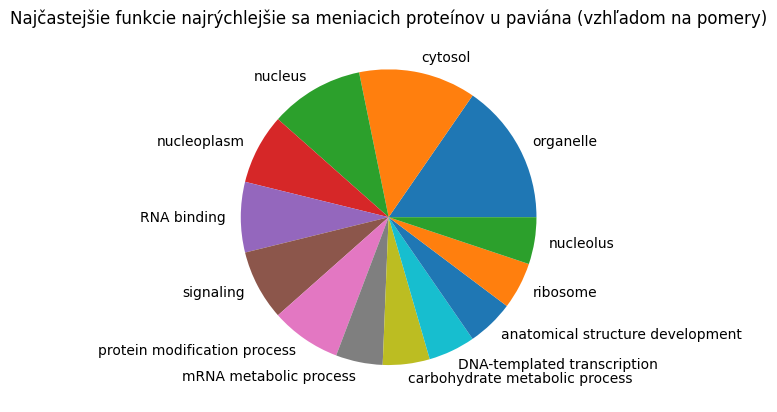

In [30]:
highest_ratio_proteins_function_ids = id.loc[list(highest_ratio_proteins)].reset_index()
function_id_frequency = highest_ratio_proteins_function_ids.groupby('go_id')['go_id'].count().sort_values(ascending=False)
function_id_frequency.name = 'count'
function_id_frequency = function_id_frequency.to_frame().query('count > 1')

named_function_frequencies = function_id_frequency.join(functions)

plt.pie(named_function_frequencies['count'], labels=named_function_frequencies['name'])
plt.title('Najčastejšie funkcie najrýchlejšie sa meniacich proteínov u paviána (vzhľadom na pomery)')
plt.show()

Vytvorili sme scatterploty, ktoré sledujú vzťah medzi pomermi 'human-baboon/human-cow', 'human-baboon/human-dog', 'human-baboon/human-mouse', 'human-baboon/human-opossum' pre jednotlivé proteíny.

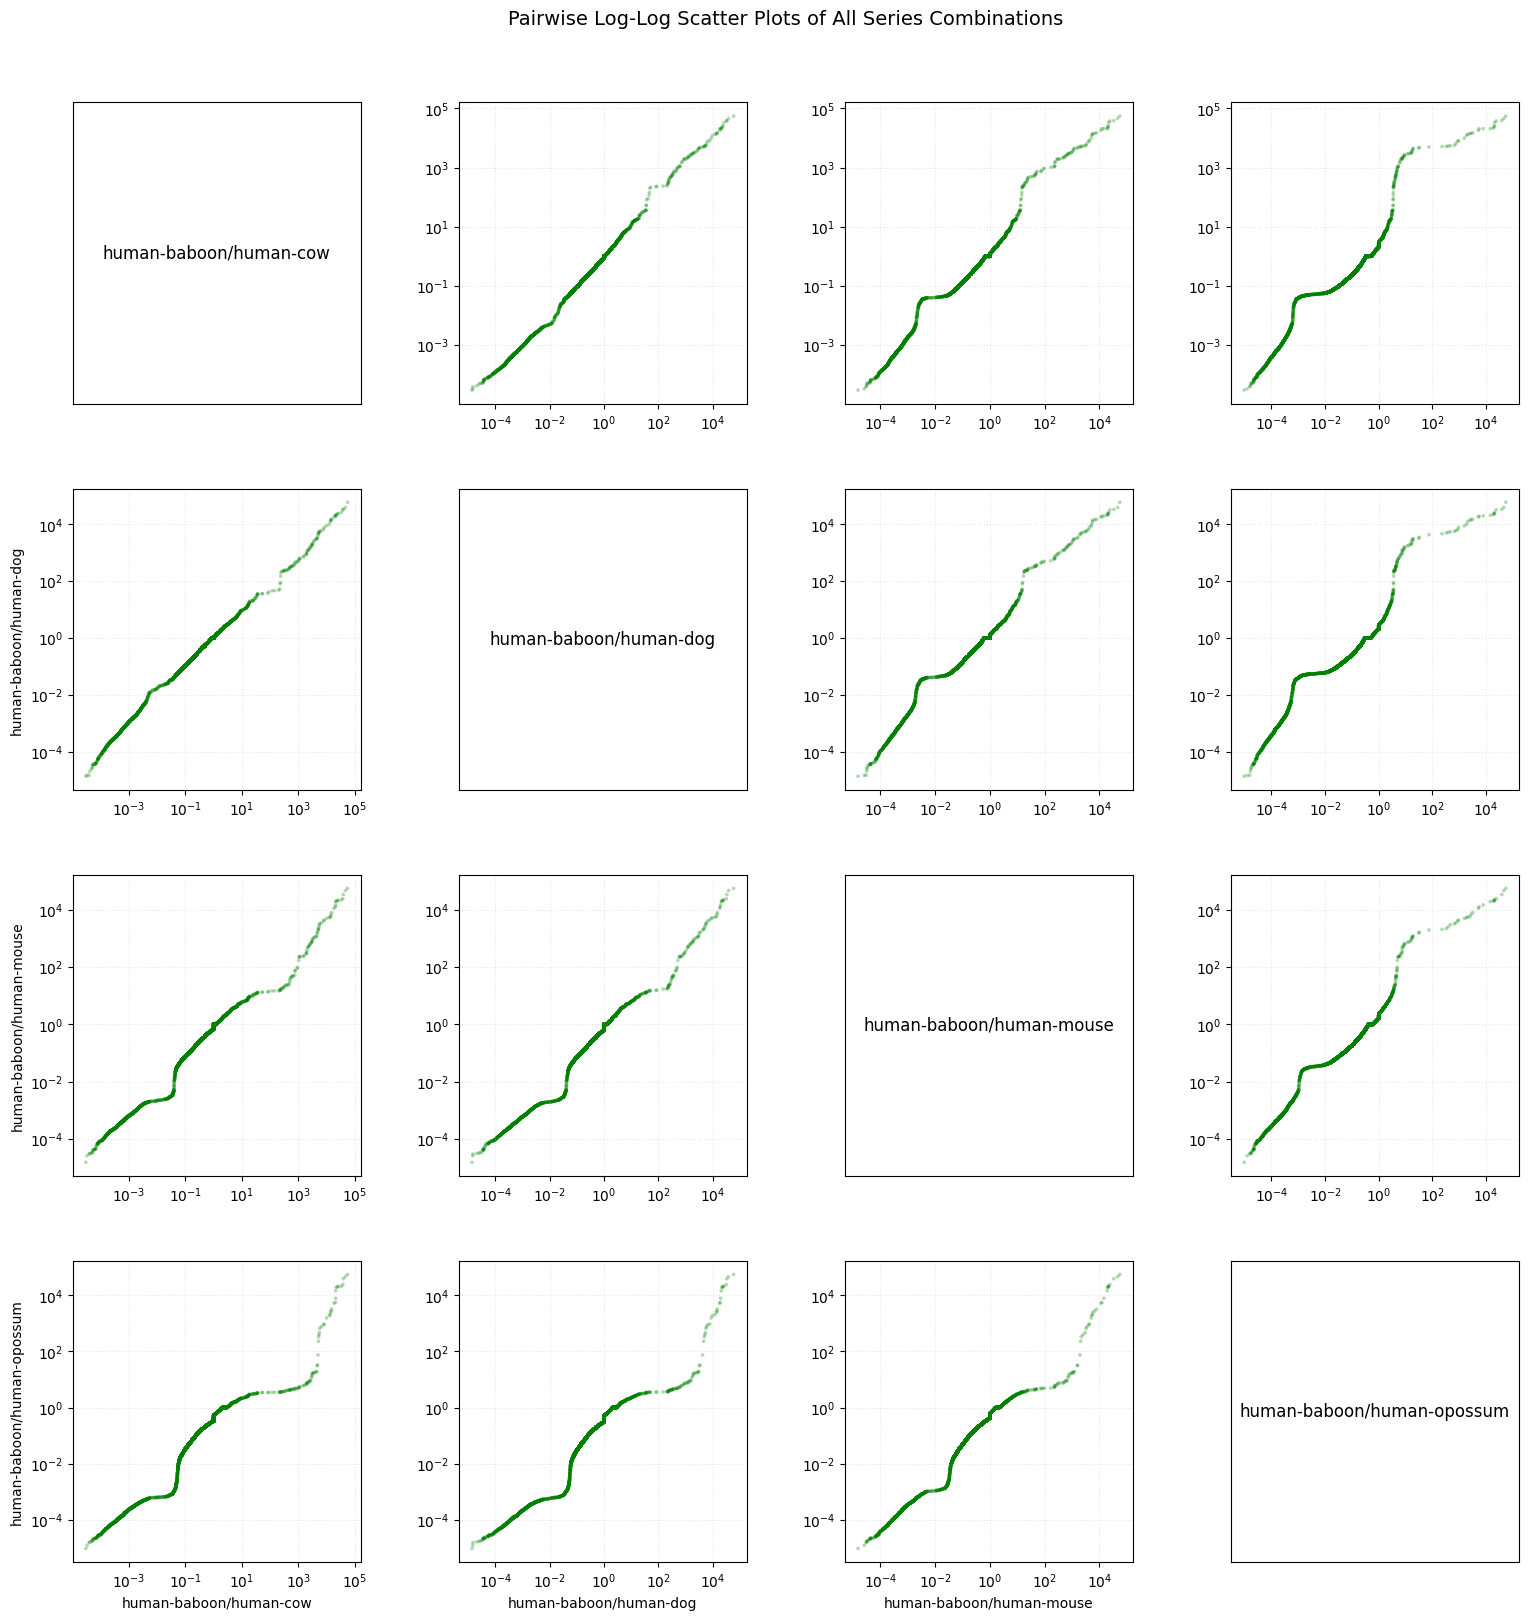

In [31]:
# Create figure and axes grid
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
fig.tight_layout(pad=4.0)

# Generate all pairwise scatter plots
for i in range(4):
    for j in range(4):
        ax = axes[i, j]

        if i == j:
            # Diagonal - could show histogram or leave empty
            ax.text(0.5, 0.5, relevant_columns[i],
                   ha='center', va='center', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # Create scatter plot with log scales
            ax.scatter(x=sorted_ratios[j], y=sorted_ratios[i],
                       s=7,           # Smaller dots (default is 20)
                       alpha=0.3,       # More transparent
                       edgecolor='none', # No border
                       color='green')
            ax.set_xscale('log')
            ax.set_yscale('log')

            # Add grid lines
            ax.grid(True, which="both", ls=":", alpha=0.3)

            # Label axes (only on edges to reduce clutter)
            if i == 3:
                ax.set_xlabel(relevant_columns[j])
            if j == 0:
                ax.set_ylabel(relevant_columns[i])

# Add overall title
plt.suptitle('Pairwise Log-Log Scatter Plots of All Series Combinations', y=1.02, fontsize=14)

plt.show()

In [32]:
def find_extreme_ratio_proteins(species, top_n=300):
  """Funkcia pomocou tabulky ratios najde proteiny, ktore pre dany druh (species)
  maju najvacsi pomer vzdialenosti od ostatnych druhov voci ostatnym parom druhov
  """
  relevant_columns = [name for name in ratios.columns
    if species in name.split('/')[0] and species not in name.split('/')[1]]
  common_extreme_proteins = None
  for col in relevant_columns:
    sorted_ratios = ratios[col].sort_values(ascending=False)
    extreme_ratios = sorted_ratios[:top_n].index
    if common_extreme_proteins is not None:
      common_extreme_proteins = common_extreme_proteins.intersection(set(extreme_ratios))
    else:
      common_extreme_proteins = set(extreme_ratios)
  return common_extreme_proteins


def count_functions(highest_ratio_proteins, cutoff=1):
  """Funkcia spocita ake funkcie maju proteiny v highest_ratio_proteins a pripadne
  odfiltruje podla pocetnosti > cutoff
  """
  valid_indices = [x for x in highest_ratio_proteins if x in goslim.index]
  highest_ratio_proteins_function_ids = goslim.loc[valid_indices].reset_index()
  function_id_frequency = highest_ratio_proteins_function_ids.groupby('go_id')['go_id'].count().sort_values(ascending=False)
  function_id_frequency.name = 'count'
  function_id_frequency = function_id_frequency.to_frame().query('count > @cutoff')
  named_function_frequencies = function_id_frequency.join(goslim_names)
  return named_function_frequencies

In [33]:
top_n_species_proteins = {}
top_n_species_proteins_counts = {}
for top_n in range(100, 1001, 100):
  top_n_species_proteins[top_n] = {}
  top_n_species_proteins_counts[top_n] = {}
  for species in ('human', 'baboon', 'cow', 'dog', 'mouse', 'opossum'):
    top_n_species_proteins[top_n][species] = find_extreme_ratio_proteins(species, top_n)
    top_n_species_proteins_counts[top_n][species] = len(top_n_species_proteins[top_n][species])

Vytvorili sme čiarový graf, ktorý znázorňuje počet najrýchlejšie sa meniacich proteínov u jednotlivých druhov.

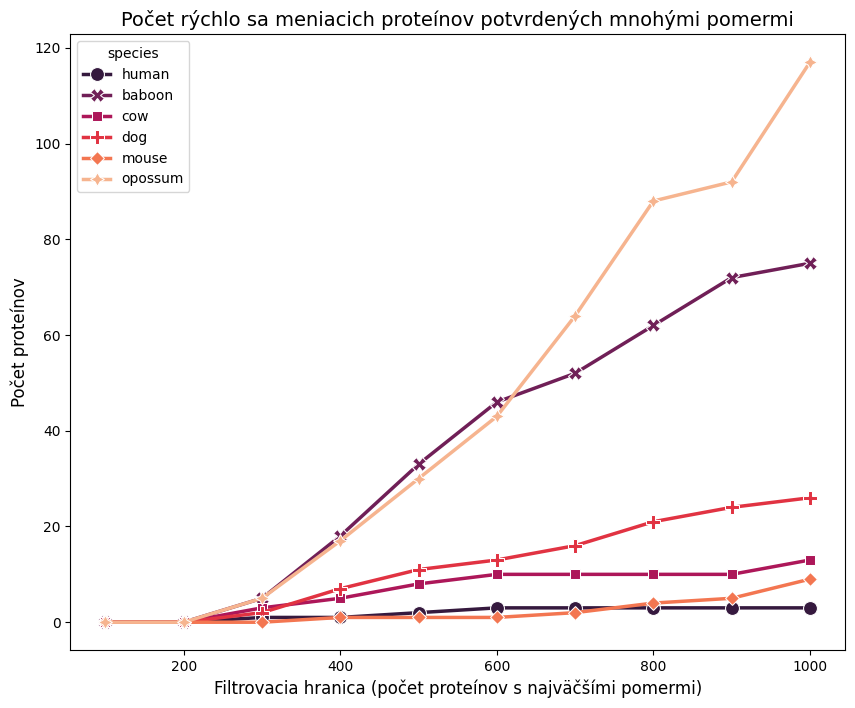

In [34]:
df_counts = pd.DataFrame(top_n_species_proteins_counts)
df_counts_long = df_counts.reset_index().melt(id_vars='index', var_name='top_n',
                                              value_name='count')
df_counts_long.rename(columns={'index': 'species'}, inplace=True)

palette = sns.color_palette("rocket")
plt.figure(figsize=(10, 8))
sns.lineplot(data=df_counts_long, x='top_n', y='count', hue='species',
             style='species', palette=palette, linewidth=2.5,
             markersize=10, markers=True, dashes=False)
plt.title("Počet rýchlo sa meniacich proteínov potvrdených mnohými pomermi", fontsize=14)
plt.xlabel("Filtrovacia hranica (počet proteínov s najväčšími pomermi)", fontsize=12)
plt.ylabel("Počet proteínov", fontsize=12)
plt.show()

V ďalších bunkách skúmame najčastejšie funkcie, ktoré majú najeýchlejšie meniace sa proteíny a porovnáme to s najčastejšími funkciami celkovo u všetkých skúmaných proteínov.

<Axes: xlabel='frequency'>

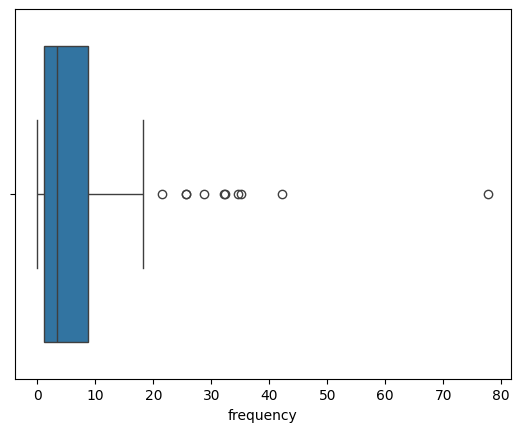

In [35]:
def compute_function_frequency_from_proteins(proteins):
  """Funkcia pomocou údajov z goslim a goslim_names pre dané proteíny (proteins)
  zistí frekvencie funkcií týchto proteínov
  """
  proteins = pd.Series(proteins, name='protein_id')
  proteins_with_go_id = id.merge(proteins, on='protein_id', how='inner')
  function_occurrences = proteins_with_go_id.groupby('go_id') \
    .agg(occurrence=('protein_id', 'count')) \
    .sort_values('occurrence', ascending=False)
  function_occurrences['frequency'] = function_occurrences['occurrence'] / len(proteins) * 100
  function_occurrences = function_occurrences.merge(functions, on='go_id', how='left')
  function_occurrences.rename(columns={'name': 'function'}, inplace=True)
  return function_occurrences

standard_frequency = compute_function_frequency_from_proteins(list(dist.index))
sns.boxplot(x=standard_frequency['frequency'])

Zameriame sa na outliery, teda funkcie s frekvenciou $\geq 20\%$.

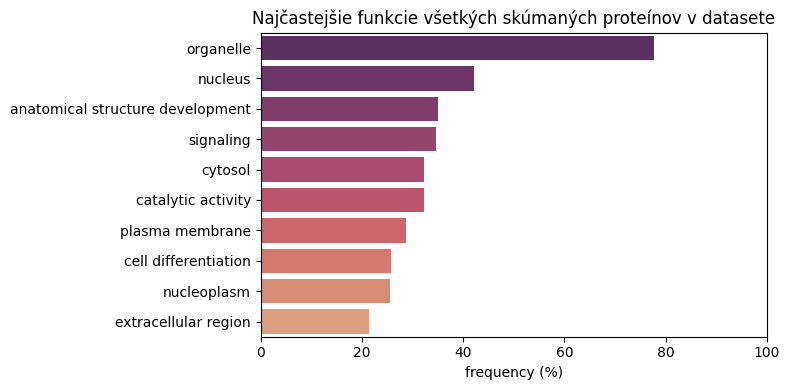

In [36]:
most_frequent = standard_frequency.query('frequency >= 20')
palette = sns.color_palette("flare_r", n_colors=len(most_frequent))
plt.figure(figsize=(8, 4))
sns.barplot(most_frequent, y='function', x='frequency',
            orient='h', hue='function', palette=palette)
plt.title('Najčastejšie funkcie všetkých skúmaných proteínov v datasete')
plt.xlabel('frequency (%)')
plt.ylabel('')
plt.xlim(0, 100)
plt.tight_layout()

<Axes: xlabel='species', ylabel='frequency'>

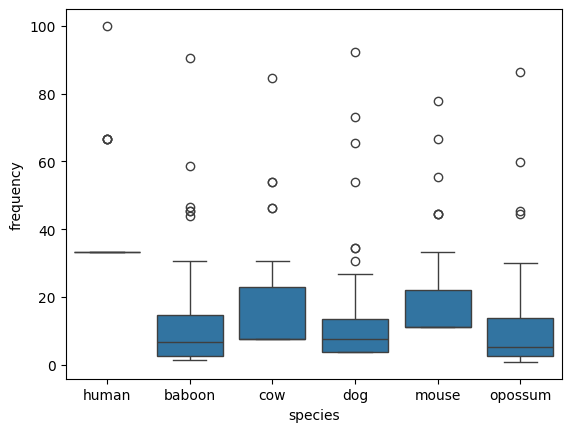

In [37]:
selected_n = 1000
species_list = []
all_data = []
for species, proteins in top_n_species_proteins[selected_n].items():
  frequencies = compute_function_frequency_from_proteins(list(proteins))
  frequencies['species'] = species
  all_data.append(frequencies)
  species_list.append(species)

frequencies = pd.concat(all_data)
sns.boxplot(data=frequencies, x='species', y='frequency')

Znova sa zameriame na outliery, s frekvenciou ≥ 30%.

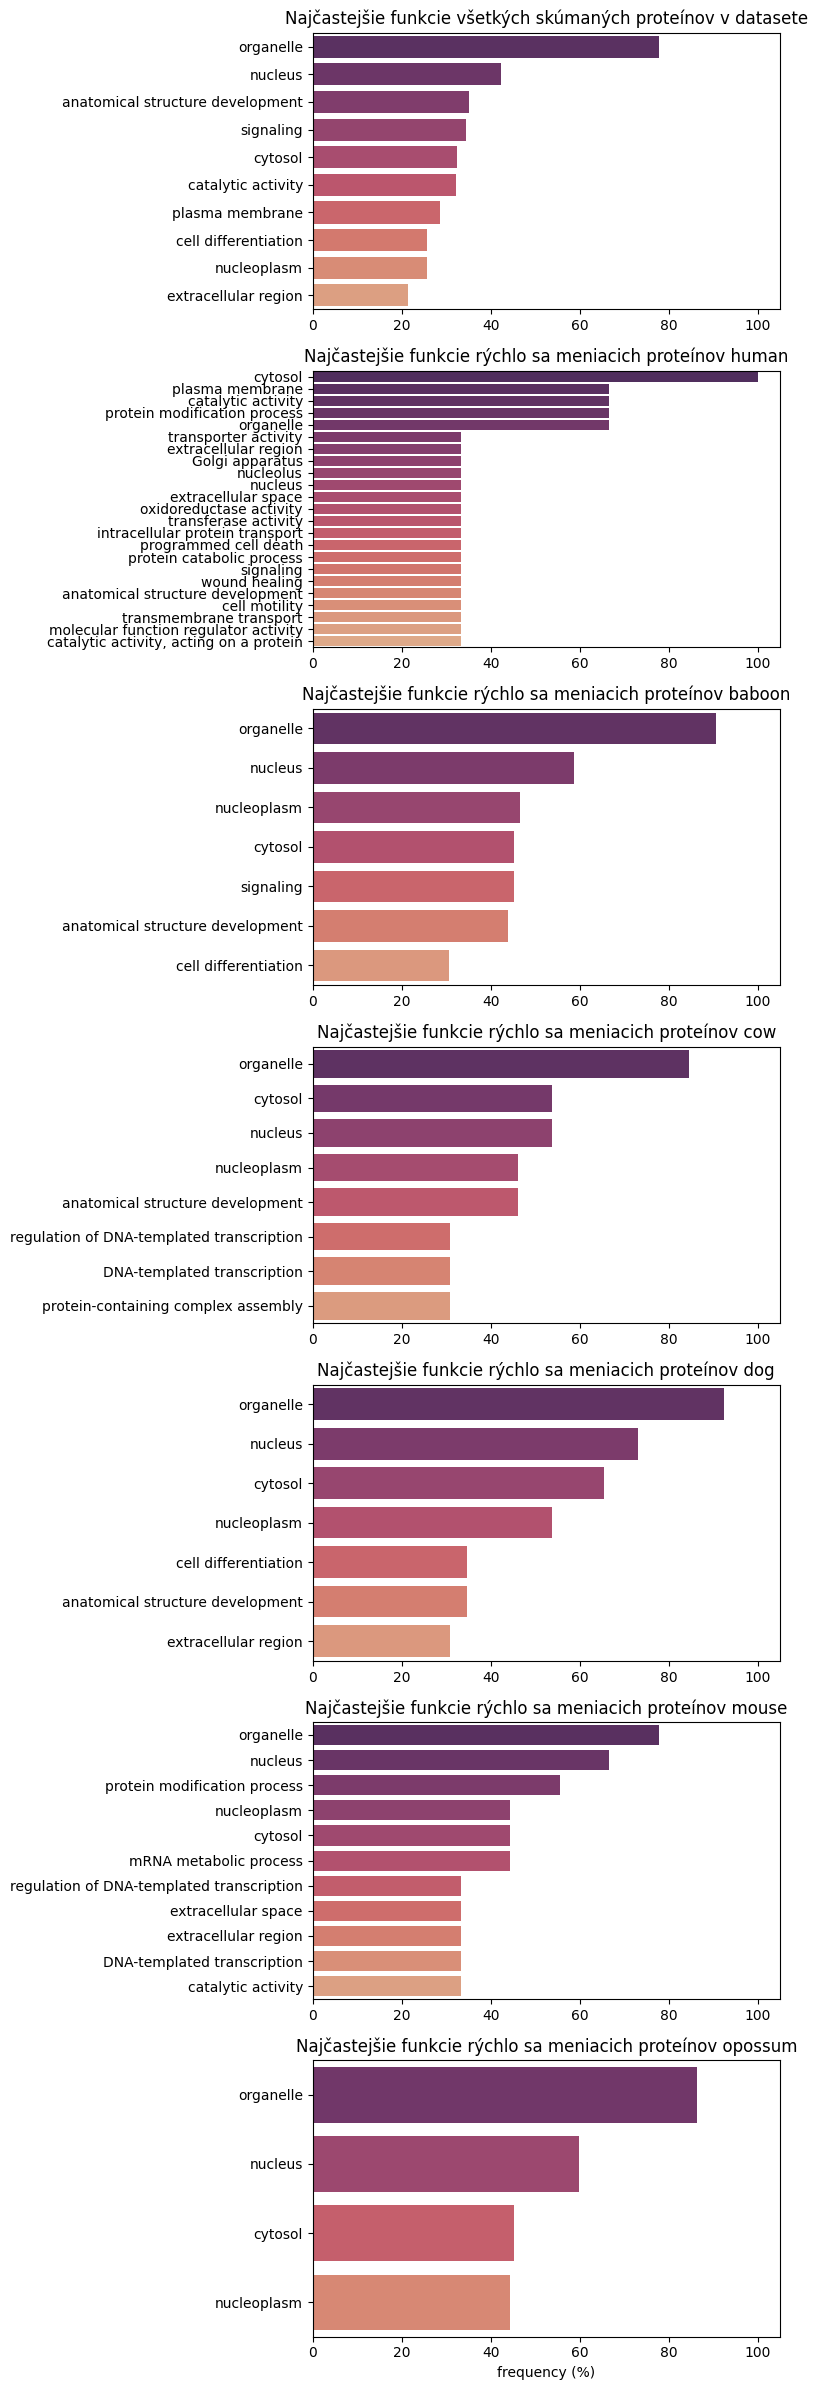

In [38]:
fig, axes = plt.subplots(len(species_list) + 1, 1, figsize=(8, 4 * len(species_list)),
                         sharex=True)
most_frequent = standard_frequency.query('frequency >= 20')
palette = sns.color_palette("flare_r", n_colors=len(most_frequent))
sns.barplot(most_frequent, y='function', x='frequency',
            orient='h', hue='function', palette=palette, ax=axes[0])
axes[0].set_title('Najčastejšie funkcie všetkých skúmaných proteínov v datasete')
axes[0].set_xlabel('frequency (%)')
axes[0].set_ylabel('')
axes[0].tick_params(labelbottom=True)

for i, (species, ax) in enumerate(zip(species_list, axes[1:])):
  most_frequent = all_data[i].query('frequency >= 30')
  palette = sns.color_palette("flare_r", n_colors=len(most_frequent))
  sns.barplot(most_frequent, y='function', x='frequency',
              orient='h', hue='function', palette=palette, ax=ax)
  ax.set_title(f'Najčastejšie funkcie rýchlo sa meniacich proteínov {species}')
  ax.set_xlabel('frequency (%)')
  ax.tick_params(labelbottom=True)
  ax.set_ylabel('')

plt.tight_layout()

In [39]:
my_query = standard_frequency.query('frequency >= 20')
display(my_query)
function_filter = my_query.index
for x in [all_data[5]]:
  my_query = x.query('frequency >= 30')
  #valid_filter = [filt for filt in function_filter if filt in my_query.index]
  display(my_query)

occurrence  frequency                          function
go_id                                                              
GO:0043226       10125  77.764977                         organelle
GO:0005634        5500  42.242704                           nucleus
GO:0048856        4563  35.046083  anatomical structure development
GO:0023052        4501  34.569892                         signaling
GO:0005829        4212  32.350230                           cytosol
GO:0003824        4191  32.188940                catalytic activity
GO:0005886        3740  28.725038                   plasma membrane
GO:0030154        3346  25.698925              cell differentiation
GO:0005654        3337  25.629800                       nucleoplasm
GO:0005576        2788  21.413210              extracellular region

occurrence  frequency     function  species
go_id                                                  
GO:0043226         101  86.324786    organelle  opossum
GO:0005634          70  59.829060      nucleus  opossum
GO:0005829          53  45.299145      cytosol  opossum
GO:0005654          52  44.444444  nucleoplasm  opossum

Proteíny sme podľa id roydelili na 3 skupiny: cellular_component, biological_process, molecular_functions.

In [40]:
mer = id.merge(functions, on='go_id', how='left')
mer = mer.set_index(id.index)
#er = mer.drop(['level_0', 'index'], axis =1)
display(mer)
molecular_functions = [
    "virus receptor activity",
    "DNA binding",
    "RNA binding",
    "cytoskeletal motor activity",
    "catalytic activity",
    "GTPase activity",
    "structural molecule activity",
    "transporter activity",
    "cytoskeletal protein binding",
    "lipid binding",
    "cyclase activity",
    "antioxidant activity",
    "oxidoreductase activity",
    "transferase activity",
    "hydrolase activity",
    "lyase activity",
    "isomerase activity",
    "ligase activity",
    "protein tag activity",
    "cargo receptor activity",
    "histone binding",
    "protein folding chaperone",
    "translation regulator activity",
    "receptor ligand activity",
    "molecular transducer activity",
    "molecular adaptor activity",
    "cell adhesion mediator activity",
    "molecular function regulator activity",
    "virus coreceptor activity",
    "catalytic activity, acting on a protein",
    "catalytic activity, acting on DNA",
    "catalytic activity, acting on RNA",
    "molecular carrier activity",
    "transcription regulator activity",
    "general transcription initiation factor activity",
    "molecular sensor activity",
    "molecular sequestering activity",
    "ATP-dependent activity"
]
cellular_components = [
    "nuclear chromosome",
    "extracellular region",
    "extracellular space",
    "nucleus",
    "nuclear envelope",
    "nucleoplasm",
    "chromosome",
    "nucleolus",
    "mitochondrion",
    "lysosome",
    "endosome",
    "vacuole",
    "peroxisome",
    "endoplasmic reticulum",
    "Golgi apparatus",
    "lipid droplet",
    "microtubule organizing center",
    "cytosol",
    "ribosome",
    "cytoskeleton",
    "plasma membrane",
    "cilium",
    "external encapsulating structure",
    "extracellular matrix",
    "cytoplasmic vesicle",
    "organelle"
]
biological_processes = [
    "mitotic cell cycle",
    "cytokinesis",
    "cytoplasmic translation",
    "immune system process",
    "muscle system process",
    "circulatory system process",
    "renal system process",
    "respiratory system process",
    "carbohydrate metabolic process",
    "generation of precursor metabolites and energy",
    "DNA replication",
    "DNA repair",
    "DNA recombination",
    "chromatin organization",
    "DNA-templated transcription",
    "regulation of DNA-templated transcription",
    "tRNA metabolic process",
    "protein folding",
    "protein glycosylation",
    "amino acid metabolic process",
    "modified amino acid metabolic process",
    "lipid metabolic process",
    "vitamin metabolic process",
    "sulfur compound metabolic process",
    "intracellular protein transport",
    "nucleocytoplasmic transport",
    "autophagy",
    "inflammatory response",
    "mitochondrion organization",
    "cytoskeleton organization",
    "microtubule-based movement",
    "peroxisome organization",
    "lysosome organization",
    "chromosome segregation",
    "cell adhesion",
    "establishment or maintenance of cell polarity",
    "programmed cell death",
    "mRNA metabolic process",
    "snRNA metabolic process",
    "vesicle-mediated transport",
    "reproductive process",
    "digestive system process",
    "signaling",
    "cell differentiation",
    "protein catabolic process",
    "extracellular matrix organization",
    "regulatory ncRNA-mediated gene silencing",
    "telomere organization",
    "cell junction organization",
    "protein modification process",
    "wound healing",
    "ribosome biogenesis",
    "cilium organization",
    "anatomical structure development",
    "cell motility",
    "nervous system process",
    "endocrine process",
    "protein maturation",
    "transmembrane transport",
    "nucleobase-containing small molecule metabolic process",
    "membrane organization",
    "protein-containing complex assembly",
    "nitrogen cycle metabolic process",
    "protein localization to plasma membrane",
    "defense response to other organism",
    "detoxification",
    "meiotic nuclear division",
    "mitotic nuclear division",
    "mitochondrial gene expression",
    "carbohydrate derivative metabolic process"
]
complete_functions = pd.DataFrame()
complete_functions['protein_id'] = list(dist.index)
cc = []
bp = []
mf = []
mer = mer.reset_index()
for i in list(dist.index):

  tab = mer[mer['protein_id'] == i]
  mf_tab = []
  cc_tab = []
  bp_tab = []
  for j in tab['name']:
    if j in molecular_functions:
      mf_tab.append(j)
    if j in cellular_components:
      cc_tab.append(j)
    if j in biological_processes:
      bp_tab.append(j)
  if mf_tab == []:
    mf.append('None')
  else:
    mf.append(mf_tab)
  if bp_tab == []:
    bp.append('None')
  else:
    bp.append(bp_tab)
  if cc_tab == []:
    cc.append('None')
  else:
    cc.append(cc_tab)
complete_functions['cellular_component'] = cc
complete_functions['biological_process'] = bp
complete_functions['molecular_functions'] = mf
display(complete_functions)


go_id                                   name
protein_id                                                   
A0A087WZ39  GO:0005886                        plasma membrane
A0A087WZ39  GO:0023052                              signaling
A0A096LP49  GO:0005815          microtubule organizing center
A0A096LP49  GO:0005856                           cytoskeleton
A0A096LP49  GO:0007010              cytoskeleton organization
...                ...                                    ...
Q9Y6Z7      GO:0098772  molecular function regulator activity
W5XKT8      GO:0022414                   reproductive process
W5XKT8      GO:0031410                    cytoplasmic vesicle
W5XKT8      GO:0043226                              organelle
W5XKT8      GO:0061024                  membrane organization

[119792 rows x 2 columns]

protein_id                                 cellular_component  \
0      A0A087WTH1                                               None   
1      A0A087WZ39                                  [plasma membrane]   
2      A0A096LP49  [microtubule organizing center, cytoskeleton, ...   
3      A0A0U1RRA0                                               None   
4      A0A126GWI2                                  [plasma membrane]   
...           ...                                                ...   
13015      Q9Y6Y8  [endoplasmic reticulum, Golgi apparatus, cytos...   
13016      Q9Y6Y9  [extracellular region, endosome, plasma membra...   
13017      Q9Y6Z7  [extracellular region, extracellular space, en...   
13018      W5XKT8                   [cytoplasmic vesicle, organelle]   
13019      X6R8D5                                               None   

                                      biological_process  \
0                                                   None   
1                                            [signaling]   
2                            [cytoskeleton organization]   
3                                                   None   
4                    [signaling, nervous system process]   
...                                                  ...   
13015  [intracellular protein transport, vesicle-medi...   
13016  [immune system process, inflammatory response,...   
13017  [immune system process, vesicle-mediated trans...   
13018      [reproductive process, membrane organization]   
13019                                               None   

                                     molecular_functions  
0                                                   None  
1                                                   None  
2                         [cytoskeletal protein binding]  
3                                                   None  
4                        [molecular transducer activity]  
...                                                  ...  
13015                                      [RNA binding]  
13016     [lipid binding, molecular transducer activity]  
13017  [receptor ligand activity, molecular function ...  
13018                                               None  
13019                                               None  

[13020 rows x 4 columns]

Vytvorili sme heatmap zobrazujúci koreláciu medzi jednotlivými dvojicami.

<Axes: >

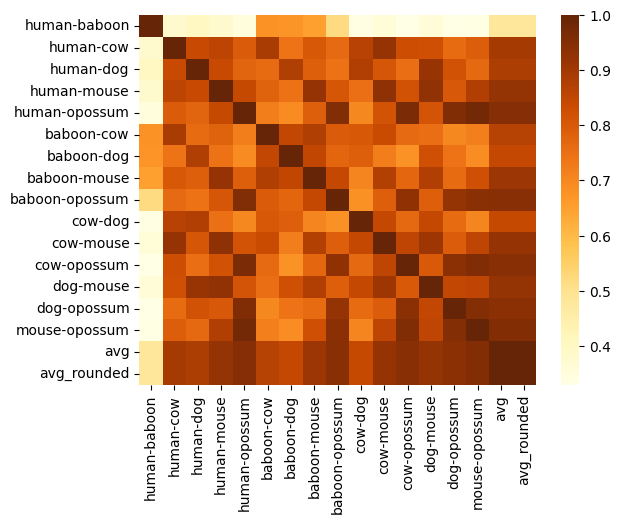

In [41]:
def make_tab(col):
  all = []
  for i in complete_functions[col]:
    if i != 'None':
     for j in i:
        all.append(j)
  tab = pd.DataFrame()
  tab[col] = list(set(all))
  count = []
  for i in tab[col]:
    count.append(all.count(i))
  tab['count'] = count
  return tab

cell_tab = make_tab('cellular_component')
func_tab = make_tab('molecular_functions')
proc_tab = make_tab('biological_process')

corr = dist.corr()
sns.heatmap(corr, cmap="YlOrBr")


Vytvorili sme ďalšie 3 heatmapy, ktoré znázorňujú počty proteínov, ktoré majú dané funkcie.

Text(220.72222222222223, 0.5, 'Cellular Component')

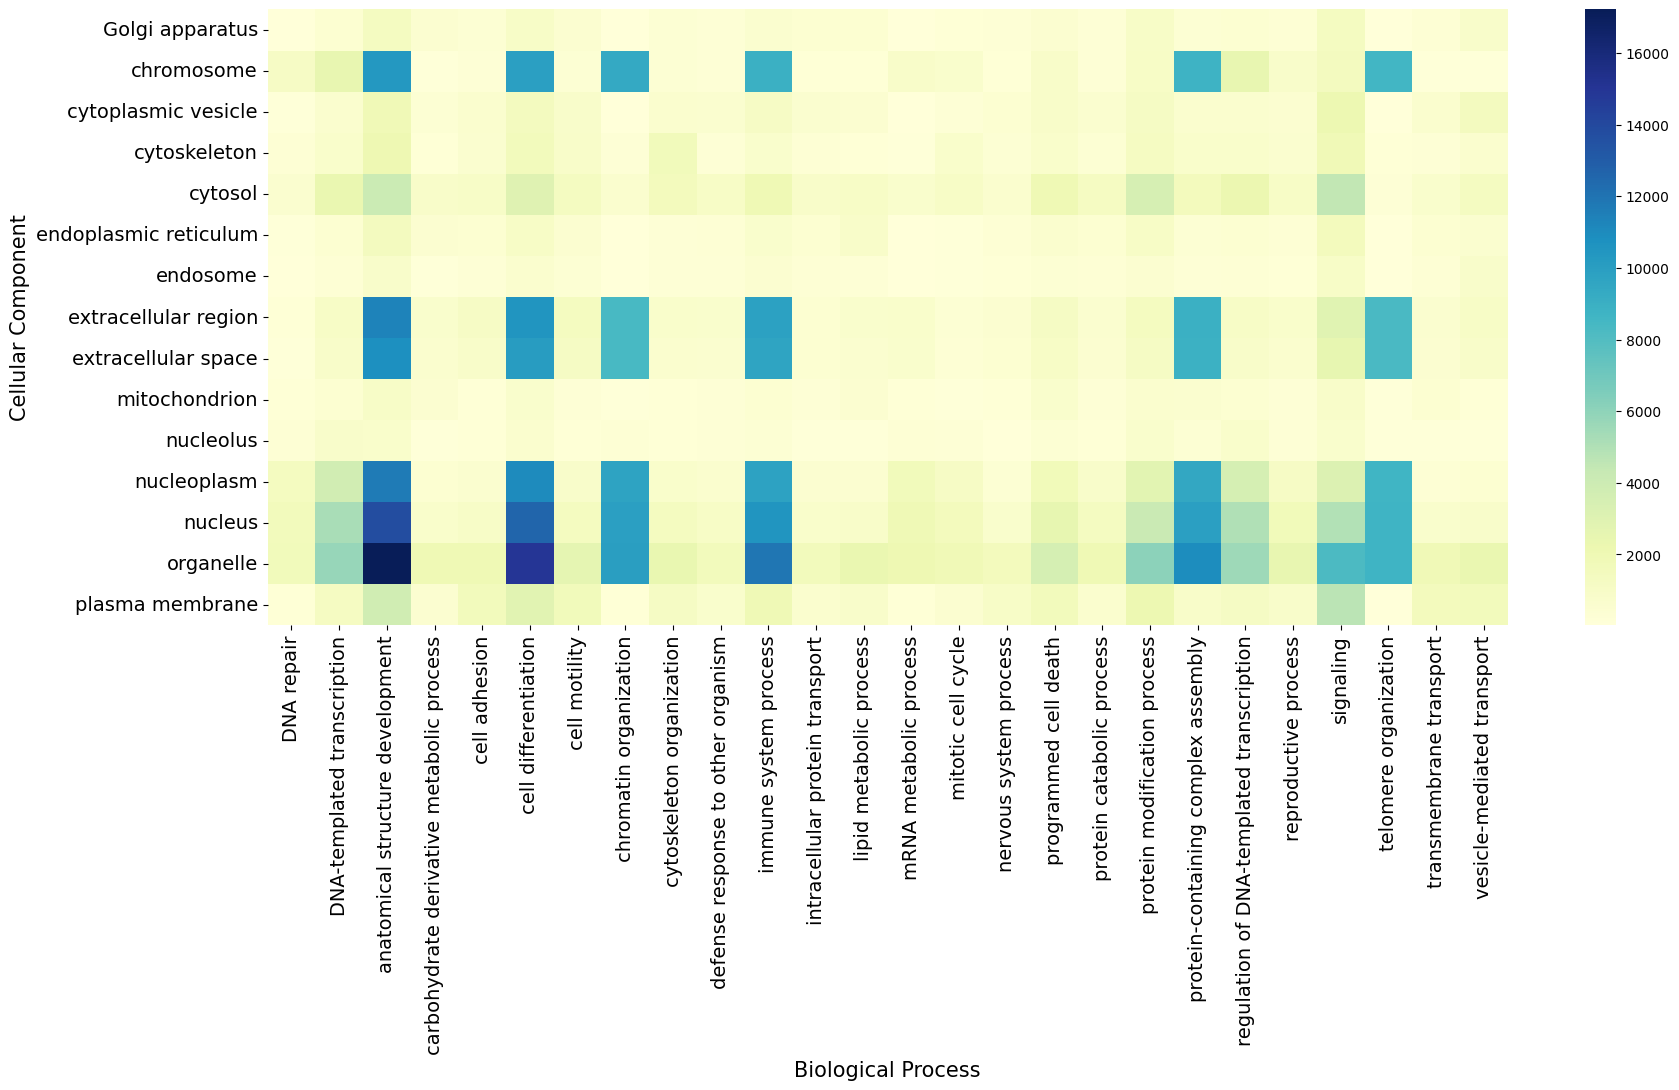

In [42]:
complete= complete_functions.explode('cellular_component').explode('biological_process').explode('molecular_functions')
def filter(df, row, col):
  df = df.loc[:, df.mean() >= row]
  df = df.loc[df.mean(axis=1) >= col]
  return df
co_occurrence = complete.groupby(['cellular_component', 'biological_process']).size().reset_index(name='count')
heatmap_data = co_occurrence.pivot_table(index='cellular_component', columns='biological_process', values='count')
heatmap_data = filter(heatmap_data, 300, 300)
plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', xticklabels= True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Biological Process', fontsize=15)
plt.ylabel('Cellular Component', fontsize=15)


molecular_functions               ATP-dependent activity  DNA binding  \
cellular_component                                                      
Golgi apparatus                                    226.0        559.0   
None                                                14.0         21.0   
chromosome                                         683.0      22326.0   
cilium                                             183.0        207.0   
cytoplasmic vesicle                                534.0        566.0   
cytoskeleton                                       658.0       1158.0   
cytosol                                           1041.0       3068.0   
endoplasmic reticulum                              310.0        452.0   
endosome                                           236.0        297.0   
external encapsulating structure                    33.0         66.0   
extracellular matrix                                33.0         66.0   
extracellular region                               665.0      17609.0   
extracellular space                                599.0      17422.0   
lipid droplet                                       50.0         28.0   
lysosome                                           235.0        131.0   
microtubule organizing center                      261.0        558.0   
mitochondrion                                      363.0        689.0   
nuclear chromosome                                 247.0        679.0   
nuclear envelope                                    93.0        404.0   
nucleolus                                          326.0       1207.0   
nucleoplasm                                       1023.0      22941.0   
nucleus                                           1392.0      25210.0   
organelle                                         2153.0      25521.0   
peroxisome                                          78.0         33.0   
plasma membrane                                    656.0        978.0   
ribosome                                            31.0        144.0   
vacuole                                            246.0        133.0   

molecular_functions               GTPase activity    None  RNA binding  \
cellular_component                                                       
Golgi apparatus                             378.0   864.0        246.0   
None                                         10.0  1034.0         83.0   
chromosome                                   27.0   768.0      17906.0   
cilium                                      126.0   919.0        127.0   
cytoplasmic vesicle                         545.0  1393.0        661.0   
cytoskeleton                                420.0  1794.0        865.0   
cytosol                                     613.0  2316.0       2971.0   
endoplasmic reticulum                       240.0   928.0        588.0   
endosome                                    311.0   706.0        219.0   
external encapsulating structure              NaN   336.0        143.0   
extracellular matrix                          NaN   336.0        143.0   
extracellular region                        500.0  1826.0      18055.0   
extracellular space                         480.0  1206.0      17950.0   
lipid droplet                                21.0    29.0         31.0   
lysosome                                    149.0   458.0        183.0   
microtubule organizing center               151.0   813.0        349.0   
mitochondrion                               160.0   630.0        813.0   
nuclear chromosome                            1.0   191.0        229.0   
nuclear envelope                             42.0   340.0        270.0   
nucleolus                                    59.0   324.0       1456.0   
nucleoplasm                                 156.0  1591.0      19840.0   
nucleus                                     344.0  2899.0      21052.0   
organelle                                   975.0  6248.0      21927.0   
peroxisome                      

Text(220.72222222222223, 0.5, 'Cellular Component')

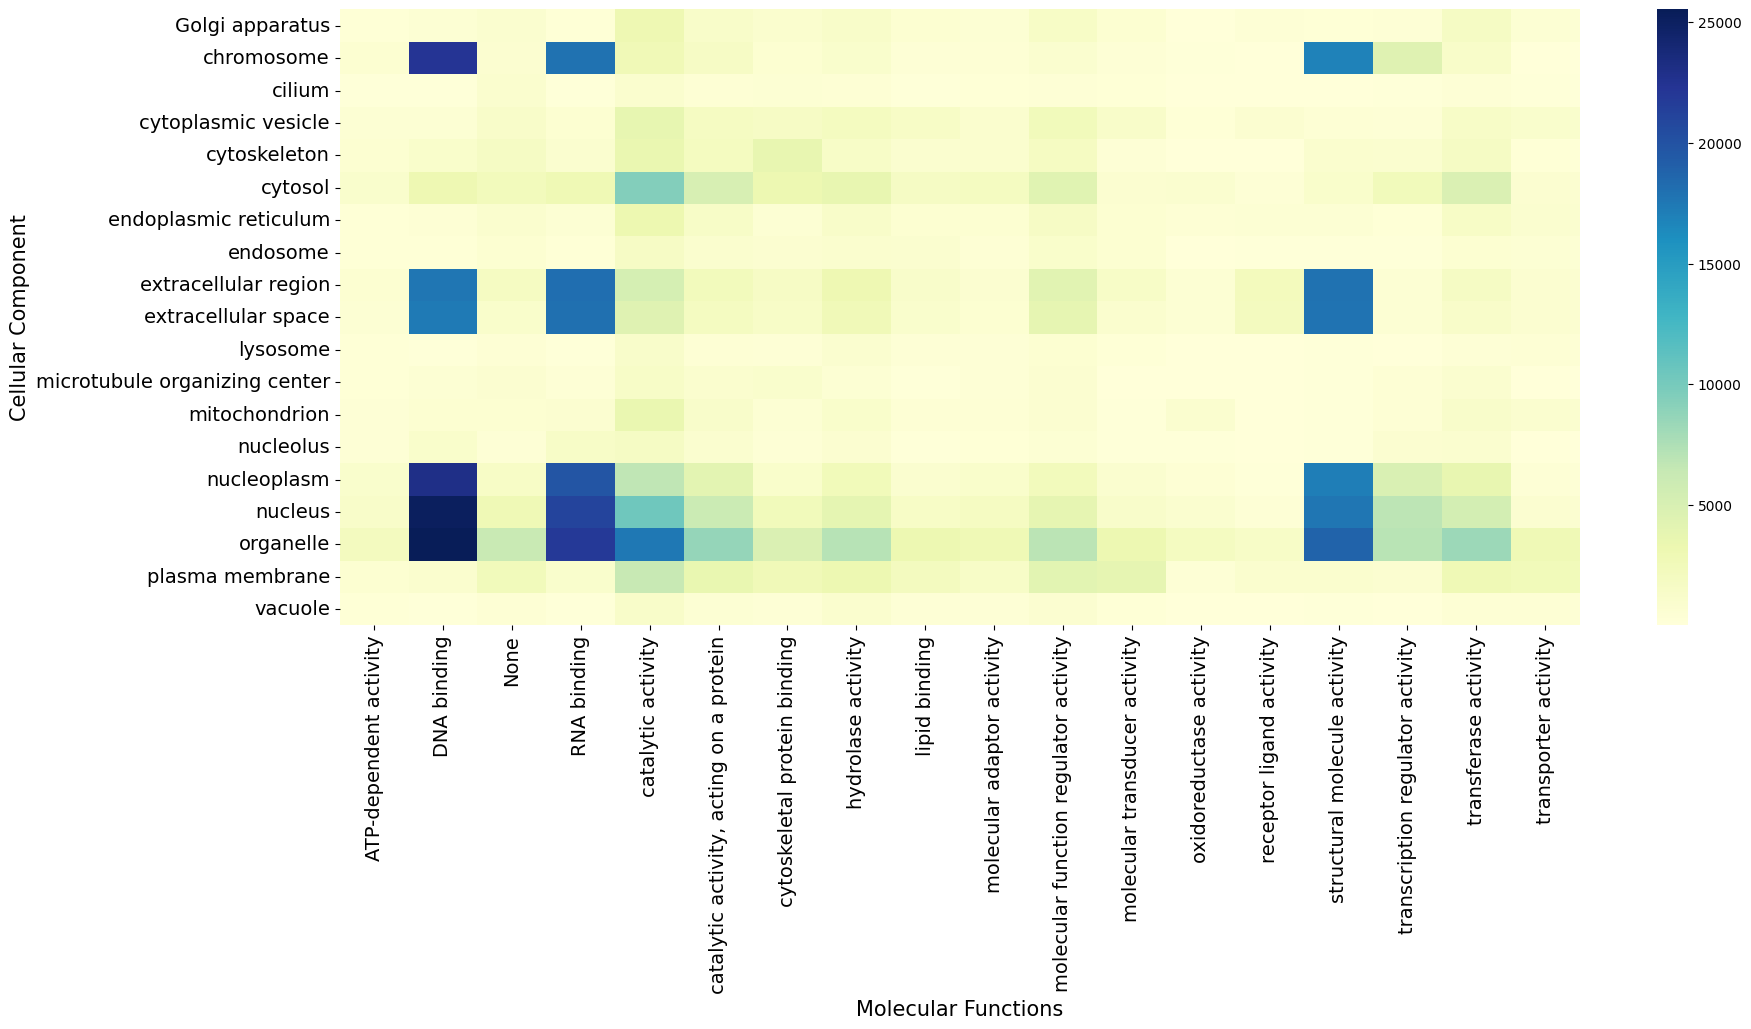

In [43]:
plt.figure(figsize=(20, 8))

co_occurrence2 = complete.groupby(['cellular_component', 'molecular_functions']).size().reset_index(name='count')
heatmap_data2 = co_occurrence2.pivot_table(index='cellular_component', columns='molecular_functions', values='count')
display(heatmap_data2)
heatmap_data2 = filter(heatmap_data2, 300, 300)
sns.heatmap(heatmap_data2, cmap='YlGnBu', xticklabels=True, yticklabels= True )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Molecular Functions', fontsize=15)
plt.ylabel('Cellular Component', fontsize=15)

Text(0.5, 58.7222222222222, 'Molecular Functions')

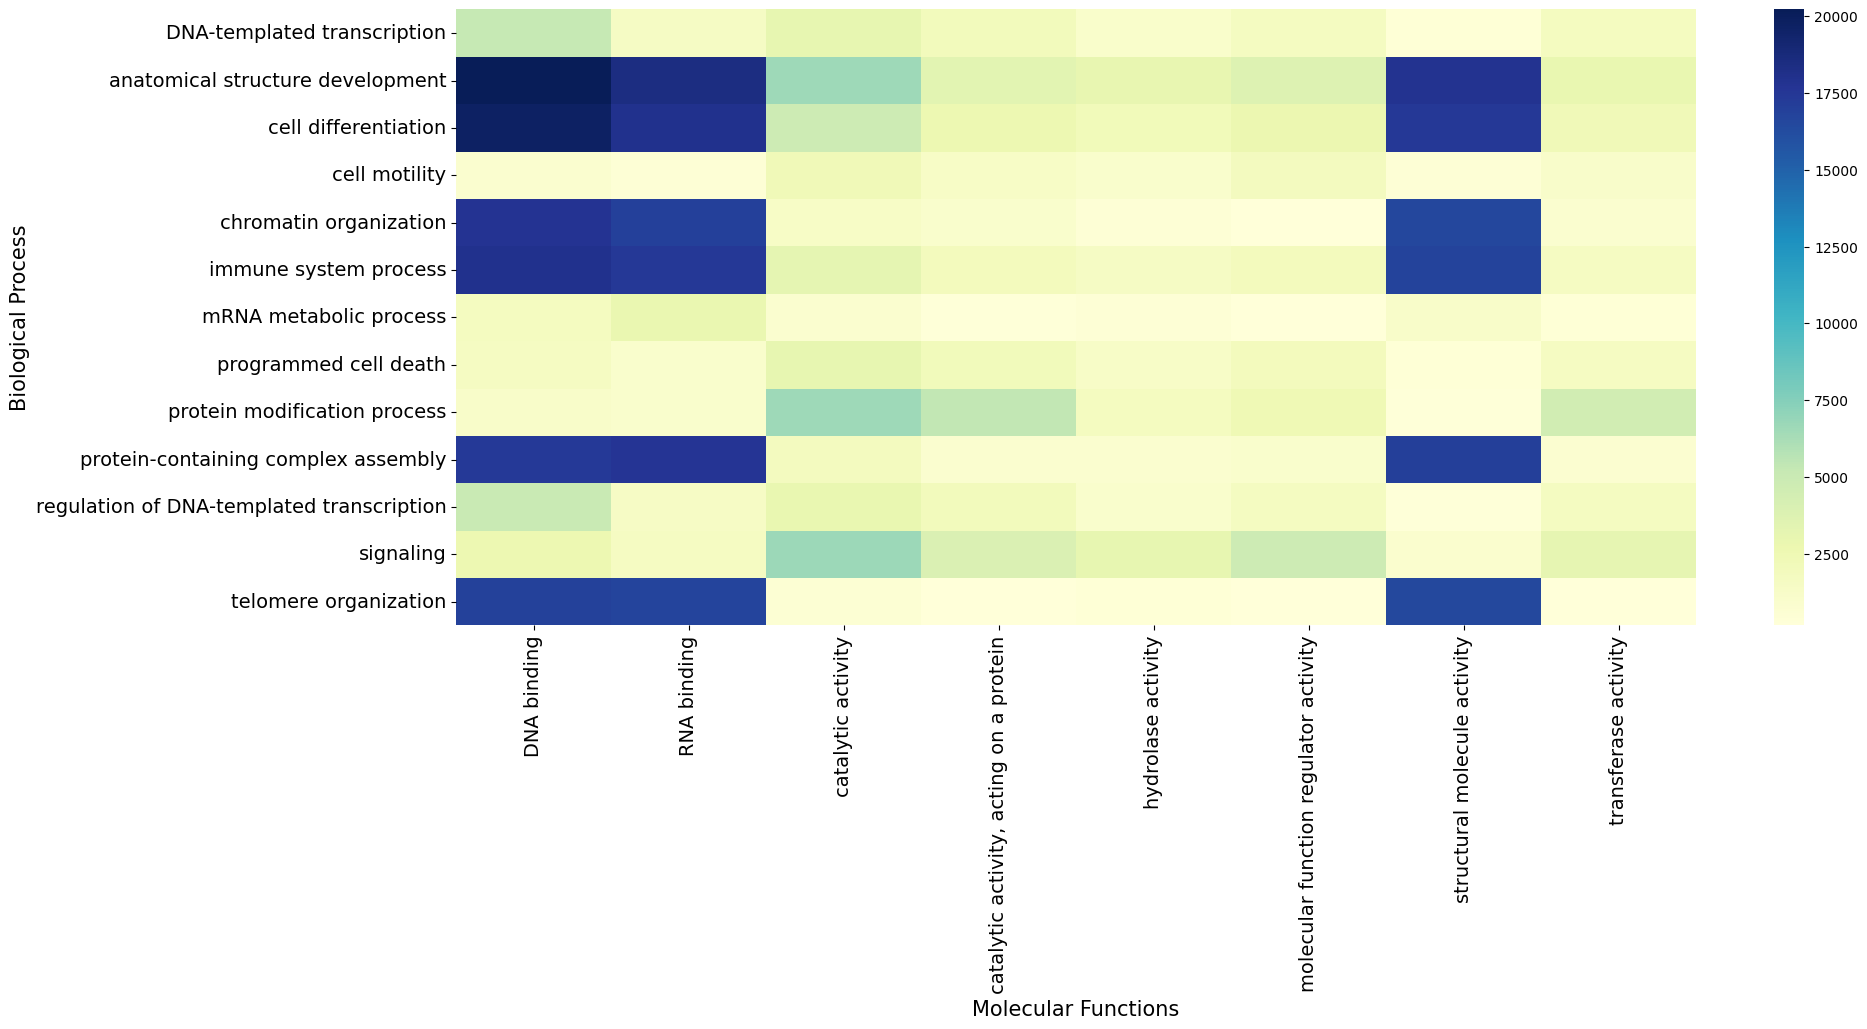

In [44]:
co_occurrence3 = complete.groupby(['biological_process', 'molecular_functions']).size().reset_index(name='count')
plt.figure(figsize=(20, 8))
heatmap_data3 = co_occurrence3.pivot_table(index='biological_process', columns='molecular_functions', values='count', fill_value=0)
heatmap_data3 = filter(heatmap_data3, 500, 1000)
sns.heatmap(heatmap_data3, cmap='YlGnBu', xticklabels=True )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Biological Process', fontsize=15)
plt.xlabel('Molecular Functions', fontsize=15)

Vytvorili sme niekoľko interaktívnych grafov, vďaka ktorým je možné sledovať vzťahy medzi proteínmi a ich funkciami.

In [45]:
new = complete
rows_to_drop = []
for index, row in new.iterrows():
    if 'None' in row.values:
        rows_to_drop.append(index)
new.drop(rows_to_drop, inplace=True)

In [46]:
new100 = new.sample(n=50, random_state=42)

edges = []

for _, row in new100.iterrows():
    cc1 = row['cellular_component']
    mf1 = row['molecular_functions']
    bp1 = row['biological_process']

    if pd.notna(cc1) and pd.notna(mf1):
        cc1_str = str(cc1).strip()
        mf1_str = str(mf1).strip()
        edge = (((cc1_str, mf1_str)))
        edges.append(edge)

    if pd.notna(mf1) and pd.notna(bp1):
        mf1_str = str(mf1).strip()
        bp1_str = str(bp1).strip()
        edge = tuple(((mf1_str, bp1_str)))
        edges.append(edge)

    if pd.notna(cc1) and pd.notna(bp1):
        mf1_str = str(cc1).strip()
        bp1_str = str(bp1).strip()
        edge = tuple(((cc1_str, bp1_str)))
        edges.append(edge)

edge_weights = Counter(edges)

G = nx.Graph()
G.add_edges_from(edge_weights.keys())

pyvis_net = Network("800px", "800px", notebook=True, cdn_resources='in_line')
pyvis_net.from_nx(G)

neighbors = pyvis_net.get_adj_list()

for node in pyvis_net.nodes:
    node_id = node["id"]
    node["title"] = node_id
    node["value"] = len(neighbors[node_id])
    node["label"] = node_id

    if node_id in new100['cellular_component'].dropna().astype(str).values:
        node["group"] = 0
        node["color"] = "magenta"

    elif node_id in new100['molecular_functions'].dropna().astype(str).values:
        node["group"] = 1
        node["color"] = "blue"
    elif node_id in new100['biological_process'].dropna().astype(str).values:
        node["group"] = 2
        node["color"] = "green"

for edge in pyvis_net.edges:
    edge_pair = tuple(((edge['from'], edge['to'])))
    edge['width'] = edge_weights.get(edge_pair, 1)
pyvis_net.show_buttons(filter_=['nodes', 'edges', 'physics', 'layout'])

pyvis_net.force_atlas_2based()
pyvis_net.show_buttons(filter_=['physics'])
pyvis_net.show("net.html")
display(HTML("net.html"))

net.html


In [47]:
for edge in pyvis_net.edges:
    edge_pair = tuple(((edge['from'], edge['to'])))
    edge_weight = edge_weights.get(edge_pair, 1)
    edge['width'] = edge_weight
    node_from = edge['from']
    node_to = edge['to']

    group_from = next((node['group'] for node in pyvis_net.nodes if node['id'] == node_from), None)
    group_to = next((node['group'] for node in pyvis_net.nodes if node['id'] == node_to), None)

    if group_from == 1 or group_to == 1:
        edge['color'] = 'blue'
    else:
        edge['color'] = 'white'

pyvis_net.show_buttons(filter_=['physics'])
pyvis_net.show("net.html")
display(HTML("net.html"))

net.html


In [48]:
for edge in pyvis_net.edges:
    edge_pair = tuple(((edge['from'], edge['to'])))
    edge_weight = edge_weights.get(edge_pair, 1)
    edge['width'] = edge_weight
    node_from = edge['from']
    node_to = edge['to']

    group_from = next((node['group'] for node in pyvis_net.nodes if node['id'] == node_from), None)
    group_to = next((node['group'] for node in pyvis_net.nodes if node['id'] == node_to), None)

    if group_from == 0 or group_to == 0:
        edge['color'] = 'magenta'
    else:
        edge['color'] = 'white'

pyvis_net.show_buttons(filter_=['physics'])
pyvis_net.show("net.html")
display(HTML("net.html"))

net.html


In [49]:
for edge in pyvis_net.edges:
    edge_pair = tuple(((edge['from'], edge['to'])))
    edge_weight = edge_weights.get(edge_pair, 1)
    edge['width'] = edge_weight
    node_from = edge['from']
    node_to = edge['to']

    group_from = next((node['group'] for node in pyvis_net.nodes if node['id'] == node_from), None)
    group_to = next((node['group'] for node in pyvis_net.nodes if node['id'] == node_to), None)

    if group_from == 2 or group_to == 2:
        edge['color'] = 'green'
    else:
        edge['color'] = 'white'

pyvis_net.show_buttons(filter_=['physics'])
pyvis_net.show("net.html")
display(HTML("net.html"))

net.html


In [53]:
categories = {
    'molecular_functions': molecular_functions,
    'cellular_components': cellular_components,
    'biological_processes': biological_processes
}
goslim = id
goslim_names = functions

Text(0.5, 1.0, 'Distribúcia go term frekvencií u všetkých skúmaných proteínov')

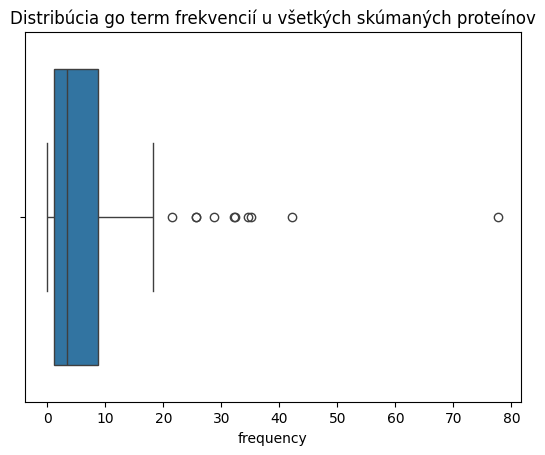

In [54]:
def compute_go_frequency_from_proteins(proteins, goslim, goslim_names):
  """Funkcia pomocou údajov z goslim a goslim_names pre dané proteíny (proteins)
  zistí frekvencie funkcií týchto proteínov
  """
  proteins = pd.Series(proteins, name='protein_id')
  proteins_with_go_id = goslim.merge(proteins, on='protein_id', how='inner')
  function_occurrences = proteins_with_go_id.groupby('go_id') \
    .agg(occurrence=('protein_id', 'count')) \
    .sort_values('occurrence', ascending=False)
  function_occurrences['frequency'] = function_occurrences['occurrence'] / len(proteins) * 100
  function_occurrences = function_occurrences.merge(goslim_names, on='go_id', how='inner')
  function_occurrences.rename(columns={'name': 'go_term'}, inplace=True)
  return function_occurrences



standard_frequency = compute_go_frequency_from_proteins(list(dist.index), goslim, goslim_names)
sns.boxplot(x=standard_frequency['frequency'])
plt.title('Distribúcia go term frekvencií u všetkých skúmaných proteínov')

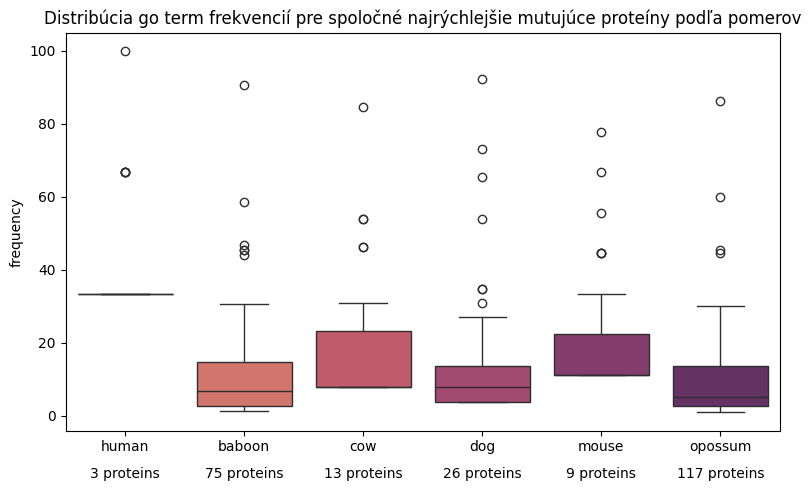

In [55]:
def compute_frequencies_for_all(selected_n, top_n_species_proteins, goslim, goslim_names):
  species_list = []
  all_frequencies = []
  counts = []
  for species, proteins in top_n_species_proteins[selected_n].items():
    frequencies = compute_go_frequency_from_proteins(list(proteins), goslim, goslim_names)
    counts.append(len(proteins))
    frequencies['species'] = species
    all_frequencies.append(frequencies)
    species_list.append(species)
  return species_list, all_frequencies, counts


species_list, all_frequencies, counts = compute_frequencies_for_all(1000, top_n_species_proteins, goslim, goslim_names)
frequencies = pd.concat(all_frequencies)
plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=frequencies, x='species', y='frequency', hue='species', palette='flare')

for tick, species in enumerate(ax.get_xticklabels()):
  name = species.get_text()
  n = counts[tick]
  ax.text(tick, ax.get_ylim()[0] - 10, f'{n} proteins',
          ha='center', va='top', fontsize=10, color='black')
plt.title('Distribúcia go term frekvencií pre spoločné najrýchlejšie mutujúce proteíny podľa pomerov')
plt.xlabel('')
plt.tight_layout()

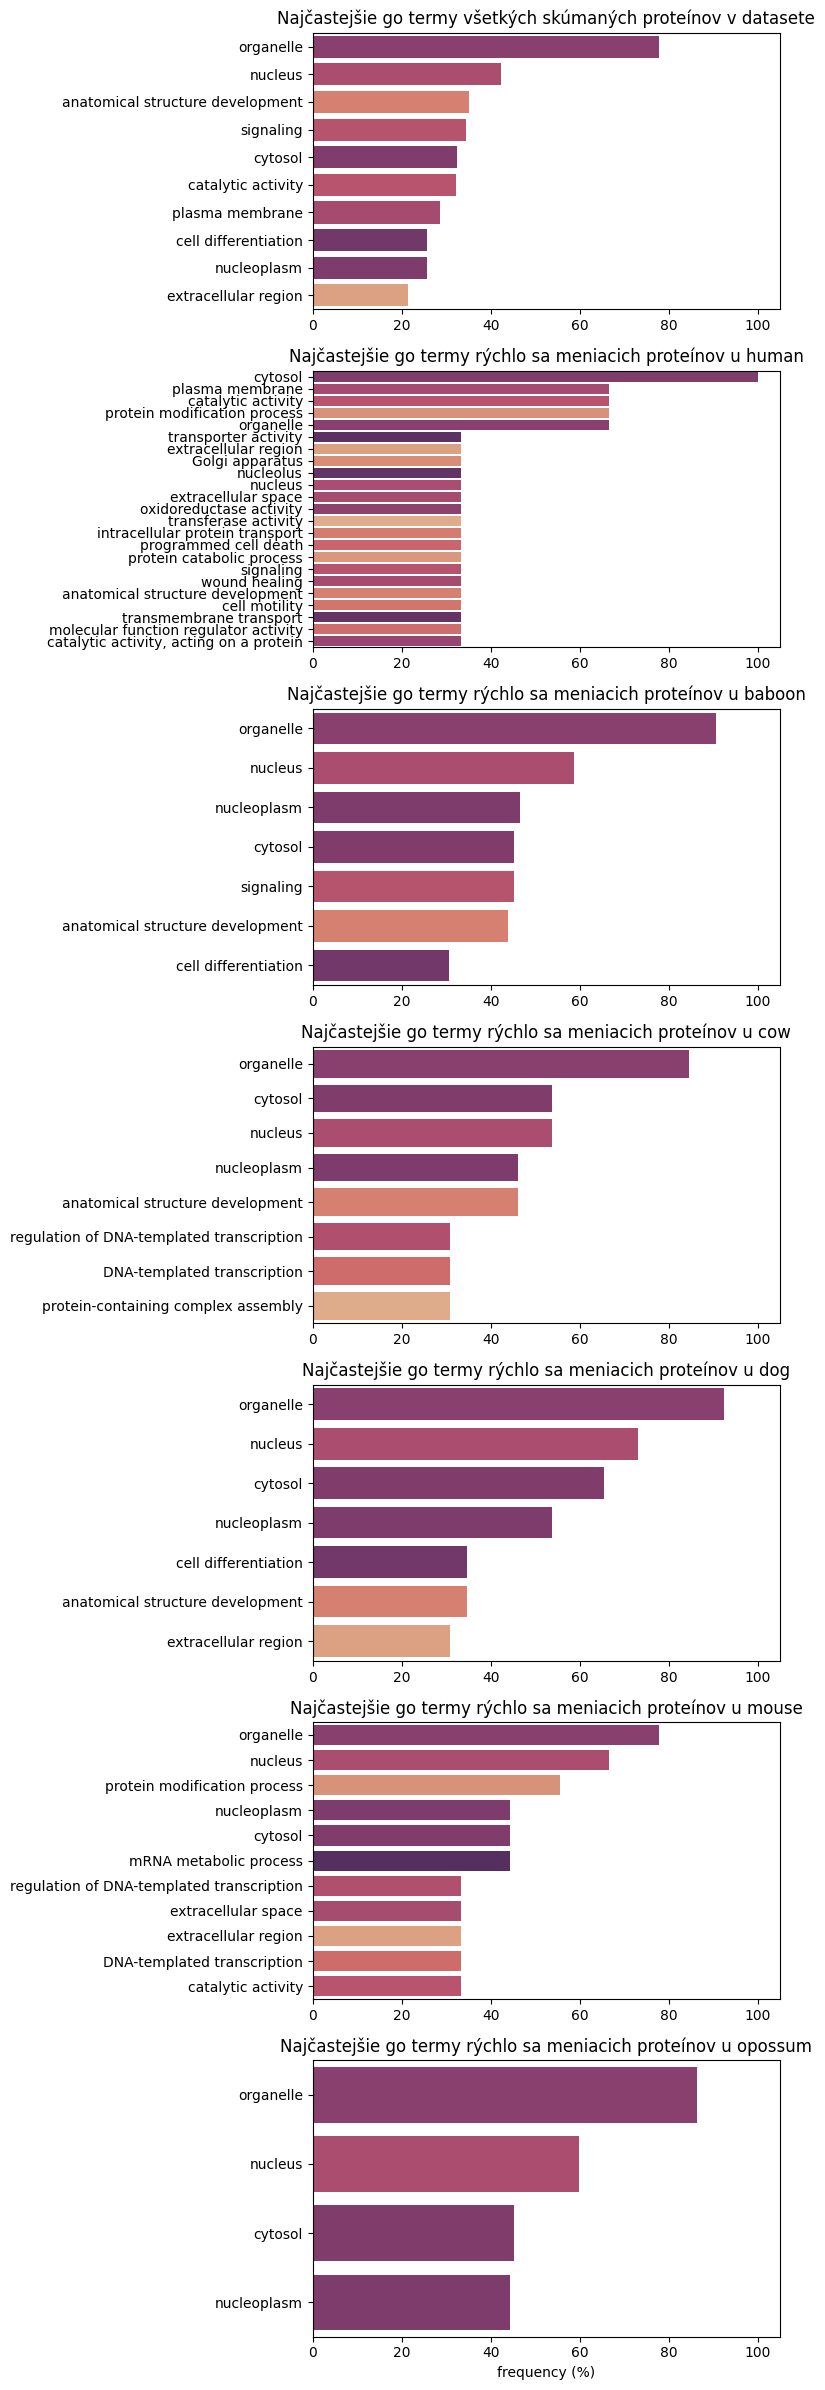

In [56]:
def frequency_barplot(all_frequencies, i, species, ax, min_freq, category='', palette=None):
  most_frequent = all_frequencies[i].query('frequency >= @min_freq')
  # palette = sns.color_palette("flare", as_cmap=True, n_colors=len(most_frequent))
  sns.barplot(most_frequent, y='go_term', x='frequency', legend=False,
              orient='h', hue='go_term', palette=palette, ax=ax)
  if category:
    category = f' pre {category}'
  if species is None:
    ax.set_title('Najčastejšie go termy všetkých skúmaných proteínov v datasete' + category)
  else:
    ax.set_title(f'Najčastejšie go termy rýchlo sa meniacich proteínov u {species}' + category)
  ax.set_xlabel('frequency (%)')
  ax.set_ylabel('')
  ax.tick_params(labelbottom=True)



fig, axes = plt.subplots(len(species_list) + 1, 1, figsize=(8, 4 * len(species_list)),
                         sharex=True)


all_functions = set(standard_frequency['go_term'])
for df in all_frequencies:
    all_functions.update(df['go_term'].unique())
function_palette = sns.color_palette("flare", n_colors=len(all_functions))
color_dict = {func: color for func, color in zip(list(all_functions), function_palette)}

frequency_barplot([standard_frequency], 0, None, axes[0], 20, '', color_dict)

for i, (species, ax) in enumerate(zip(species_list, axes[1:])):
  frequency_barplot(all_frequencies, i, species, ax, 30, '', color_dict)

plt.tight_layout()
plt.show()

In [57]:
my_query = standard_frequency.query('frequency >= 20')
display(my_query)
function_filter = my_query.index
for x in all_frequencies:
  my_query = x.query('frequency >= 20')
  #valid_filter = [filt for filt in function_filter if filt in my_query.index]
  display(my_query)

occurrence  frequency                           go_term
go_id                                                              
GO:0043226       10125  77.764977                         organelle
GO:0005634        5500  42.242704                           nucleus
GO:0048856        4563  35.046083  anatomical structure development
GO:0023052        4501  34.569892                         signaling
GO:0005829        4212  32.350230                           cytosol
GO:0003824        4191  32.188940                catalytic activity
GO:0005886        3740  28.725038                   plasma membrane
GO:0030154        3346  25.698925              cell differentiation
GO:0005654        3337  25.629800                       nucleoplasm
GO:0005576        2788  21.413210              extracellular region

occurrence   frequency                                  go_term  \
go_id                                                                         
GO:0005829           3  100.000000                                  cytosol   
GO:0005886           2   66.666667                          plasma membrane   
GO:0003824           2   66.666667                       catalytic activity   
GO:0036211           2   66.666667             protein modification process   
GO:0043226           2   66.666667                                organelle   
GO:0005215           1   33.333333                     transporter activity   
GO:0005576           1   33.333333                     extracellular region   
GO:0005794           1   33.333333                          Golgi apparatus   
GO:0005730           1   33.333333                                nucleolus   
GO:0005634           1   33.333333                                  nucleus   
GO:0005615           1   33.333333                      extracellular space   
GO:0016491           1   33.333333                  oxidoreductase activity   
GO:0016740           1   33.333333                     transferase activity   
GO:0006886           1   33.333333          intracellular protein transport   
GO:0012501           1   33.333333                    programmed cell death   
GO:0030163           1   33.333333                protein catabolic process   
GO:0023052           1   33.333333                                signaling   
GO:0042060           1   33.333333                            wound healing   
GO:0048856           1   33.333333         anatomical structure development   
GO:0048870           1   33.333333                            cell motility   
GO:0055085           1   33.333333                  transmembrane transport   
GO:0098772           1   33.333333    molecular function regulator activity   
GO:0140096           1   33.333333  catalytic activity, acting on a protein   

           species  
go_id               
GO:0005829   human  
GO:0005886   human  
GO:0003824   human  
GO:0036211   human  
GO:0043226   human  
GO:0005215   human  
GO:0005576   human  
GO:0005794   human  
GO:0005730   human  
GO:0005634   human  
GO:0005615   human  
GO:0016491   human  
GO:0016740   human  
GO:0006886   human  
GO:0012501   human  
GO:0030163   human  
GO:0023052   human  
GO:0042060   human  
GO:0048856   human  
GO:0048870   human  
GO:0055085   human  
GO:0098772   human  
GO:0140096   human

occurrence  frequency                           go_term species
go_id                                                                      
GO:0043226          68  90.666667                         organelle  baboon
GO:0005634          44  58.666667                           nucleus  baboon
GO:0005654          35  46.666667                       nucleoplasm  baboon
GO:0005829          34  45.333333                           cytosol  baboon
GO:0023052          34  45.333333                         signaling  baboon
GO:0048856          33  44.000000  anatomical structure development  baboon
GO:0030154          23  30.666667              cell differentiation  baboon
GO:0006351          18  24.000000       DNA-templated transcription  baboon
GO:0005886          17  22.666667                   plasma membrane  baboon
GO:0003824          16  21.333333                catalytic activity  baboon
GO:0005576          16  21.333333              extracellular region  baboon
GO:0036211          15  20.000000      protein modification process  baboon
GO:0003723          15  20.000000                       RNA binding  baboon

occurrence  frequency                                    go_term  \
go_id                                                                          
GO:0043226          11  84.615385                                  organelle   
GO:0005829           7  53.846154                                    cytosol   
GO:0005634           7  53.846154                                    nucleus   
GO:0005654           6  46.153846                                nucleoplasm   
GO:0048856           6  46.153846           anatomical structure development   
GO:0006355           4  30.769231  regulation of DNA-templated transcription   
GO:0006351           4  30.769231                DNA-templated transcription   
GO:0065003           4  30.769231        protein-containing complex assembly   
GO:0003677           3  23.076923                                DNA binding   
GO:0003824           3  23.076923                         catalytic activity   
GO:0030154           3  23.076923                       cell differentiation   
GO:0003723           3  23.076923                                RNA binding   
GO:0036211           3  23.076923               protein modification process   
GO:0006886           3  23.076923            intracellular protein transport   

           species  
go_id               
GO:0043226     cow  
GO:0005829     cow  
GO:0005634     cow  
GO:0005654     cow  
GO:0048856     cow  
GO:0006355     cow  
GO:0006351     cow  
GO:0065003     cow  
GO:0003677     cow  
GO:0003824     cow  
GO:0030154     cow  
GO:0003723     cow  
GO:0036211     cow  
GO:0006886     cow

occurrence  frequency                                    go_term  \
go_id                                                                          
GO:0043226          24  92.307692                                  organelle   
GO:0005634          19  73.076923                                    nucleus   
GO:0005829          17  65.384615                                    cytosol   
GO:0005654          14  53.846154                                nucleoplasm   
GO:0030154           9  34.615385                       cell differentiation   
GO:0048856           9  34.615385           anatomical structure development   
GO:0005576           8  30.769231                       extracellular region   
GO:0006355           7  26.923077  regulation of DNA-templated transcription   
GO:0006351           7  26.923077                DNA-templated transcription   
GO:0003824           6  23.076923                         catalytic activity   
GO:0023052           6  23.076923                                  signaling   
GO:0003723           6  23.076923                                RNA binding   

           species  
go_id               
GO:0043226     dog  
GO:0005634     dog  
GO:0005829     dog  
GO:0005654     dog  
GO:0030154     dog  
GO:0048856     dog  
GO:0005576     dog  
GO:0006355     dog  
GO:0006351     dog  
GO:0003824     dog  
GO:0023052     dog  
GO:0003723     dog

occurrence  frequency                                    go_term  \
go_id                                                                          
GO:0043226           7  77.777778                                  organelle   
GO:0005634           6  66.666667                                    nucleus   
GO:0036211           5  55.555556               protein modification process   
GO:0005654           4  44.444444                                nucleoplasm   
GO:0005829           4  44.444444                                    cytosol   
GO:0016071           4  44.444444                     mRNA metabolic process   
GO:0006355           3  33.333333  regulation of DNA-templated transcription   
GO:0005615           3  33.333333                        extracellular space   
GO:0005576           3  33.333333                       extracellular region   
GO:0006351           3  33.333333                DNA-templated transcription   
GO:0003824           3  33.333333                         catalytic activity   
GO:0003677           2  22.222222                                DNA binding   
GO:0016192           2  22.222222                 vesicle-mediated transport   
GO:0023052           2  22.222222                                  signaling   
GO:0048856           2  22.222222           anatomical structure development   
GO:0030154           2  22.222222                       cell differentiation   
GO:0007010           2  22.222222                  cytoskeleton organization   
GO:0003723           2  22.222222                                RNA binding   
GO:0005886           2  22.222222                            plasma membrane   
GO:0051604           2  22.222222                         protein maturation   
GO:0140096           2  22.222222    catalytic activity, acting on a protein   
GO:0065003           2  22.222222        protein-containing complex assembly   
GO:0098772           2  22.222222      molecular function regulator activity   

           species  
go_id               
GO:0043226   mouse  
GO:0005634   mouse  
GO:0036211   mouse  
GO:0005654   mouse  
GO:0005829   mouse  
GO:0016071   mouse  
GO:0006355   mouse  
GO:0005615   mouse  
GO:0005576   mouse  
GO:0006351   mouse  
GO:0003824   mouse  
GO:0003677   mouse  
GO:0016192   mouse  
GO:0023052   mouse  
GO:0048856   mouse  
GO:0030154   mouse  
GO:0007010   mouse  
GO:0003723   mouse  
GO:0005886   mouse  
GO:0051604   mouse  
GO:0140096   mouse  
GO:0065003   mouse  
GO:0098772   mouse

occurrence  frequency                                    go_term  \
go_id                                                                          
GO:0043226         101  86.324786                                  organelle   
GO:0005634          70  59.829060                                    nucleus   
GO:0005829          53  45.299145                                    cytosol   
GO:0005654          52  44.444444                                nucleoplasm   
GO:0003723          35  29.914530                                RNA binding   
GO:0048856          35  29.914530           anatomical structure development   
GO:0005576          32  27.350427                       extracellular region   
GO:0023052          32  27.350427                                  signaling   
GO:0005615          30  25.641026                        extracellular space   
GO:0006351          29  24.786325                DNA-templated transcription   
GO:0003824          29  24.786325                         catalytic activity   
GO:0005886          28  23.931624                            plasma membrane   
GO:0006355          27  23.076923  regulation of DNA-templated transcription   
GO:0065003          26  22.222222        protein-containing complex assembly   
GO:0030154          26  22.222222                       cell differentiation   
GO:0036211          24  20.512821               protein modification process   

            species  
go_id                
GO:0043226  opossum  
GO:0005634  opossum  
GO:0005829  opossum  
GO:0005654  opossum  
GO:0003723  opossum  
GO:0048856  opossum  
GO:0005576  opossum  
GO:0023052  opossum  
GO:0005615  opossum  
GO:0006351  opossum  
GO:0003824  opossum  
GO:0005886  opossum  
GO:0006355  opossum  
GO:0065003  opossum  
GO:0030154  opossum  
GO:0036211  opossum

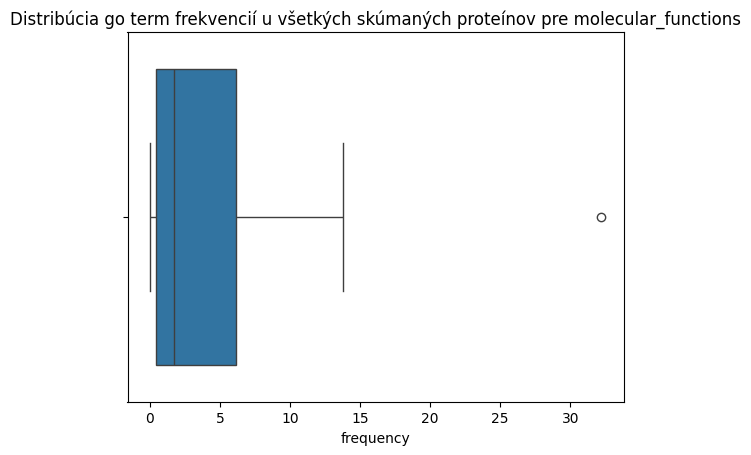

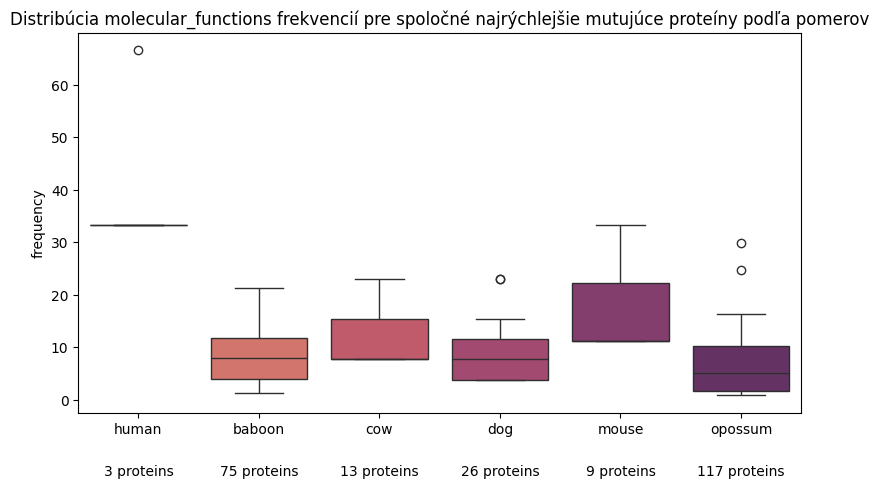

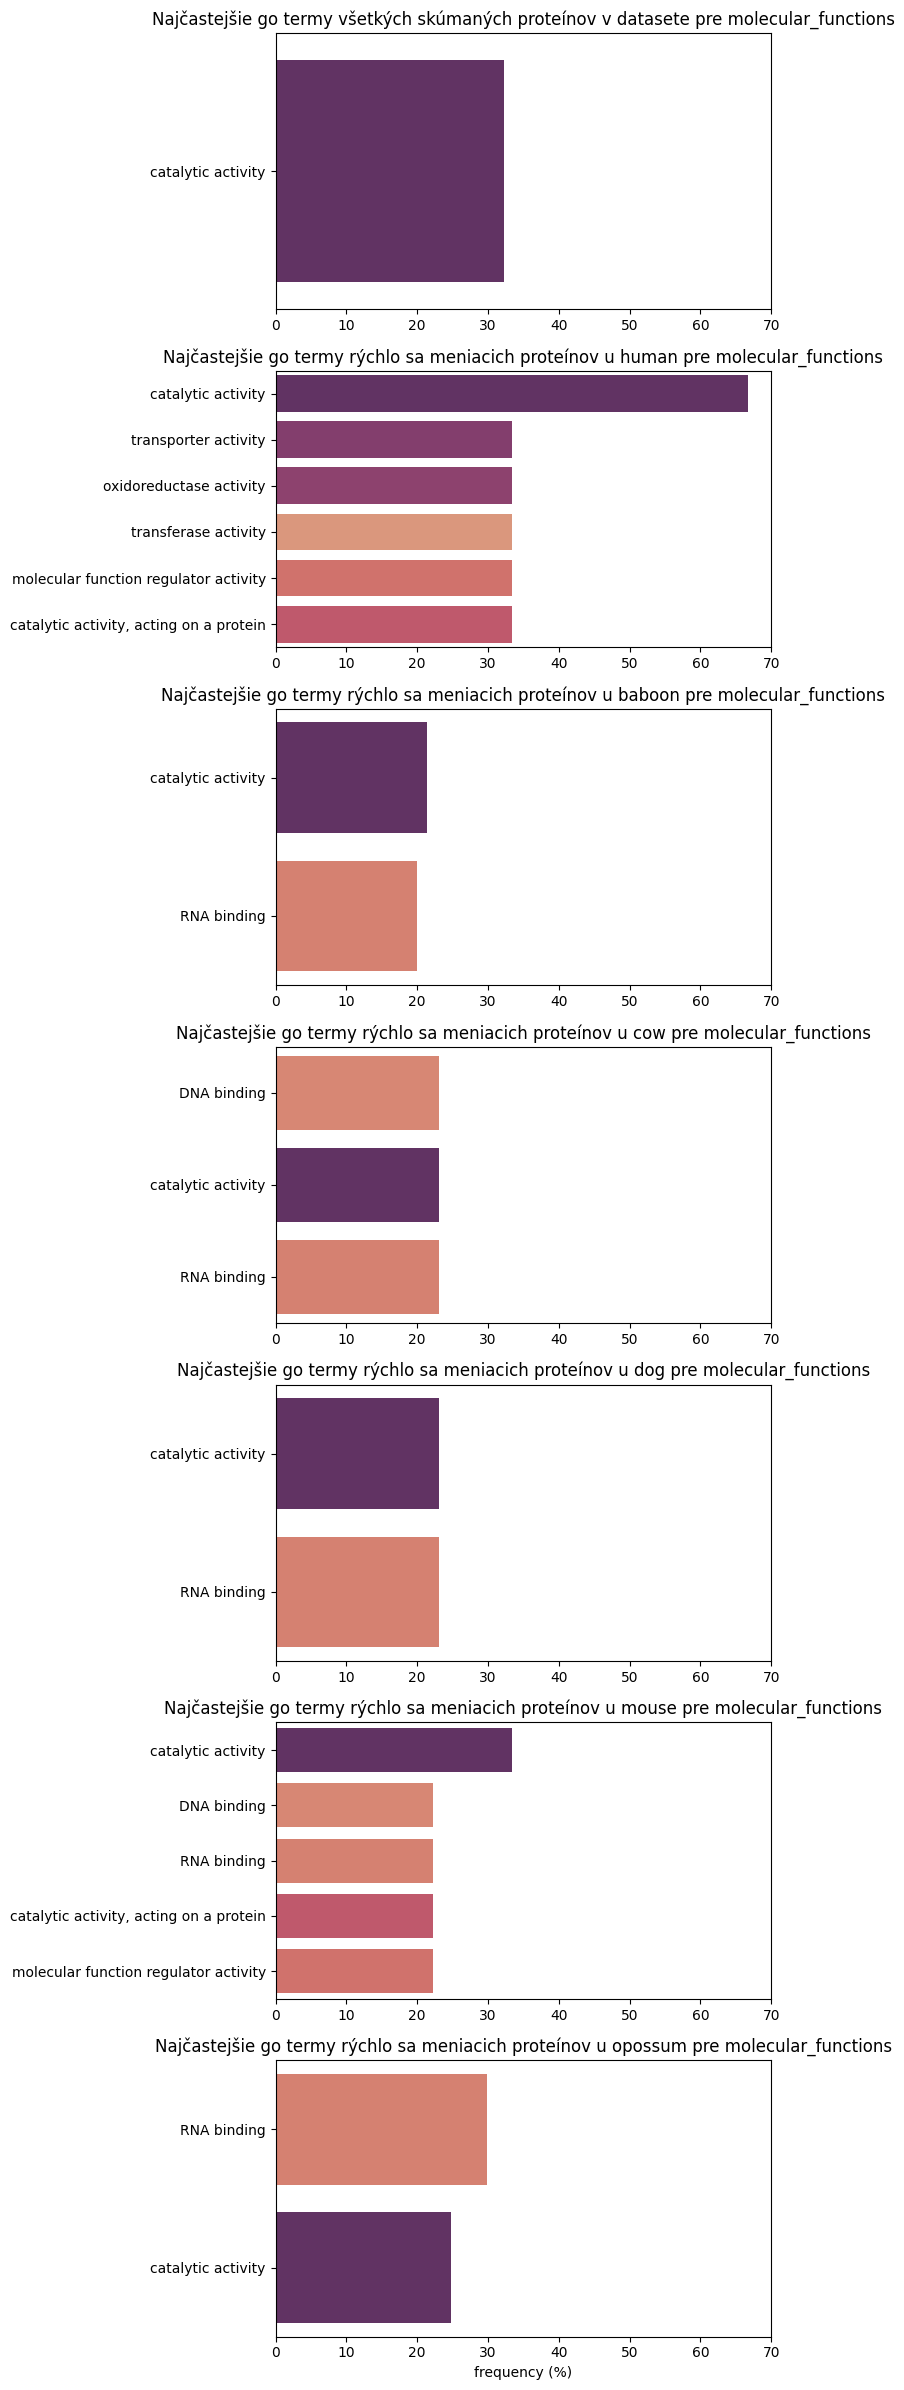

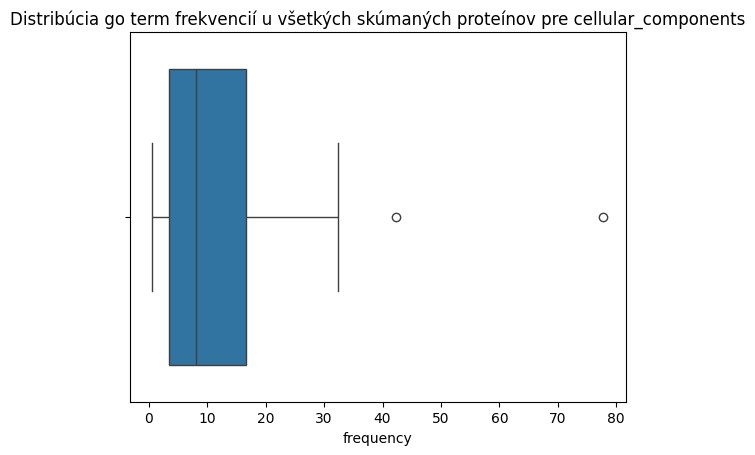

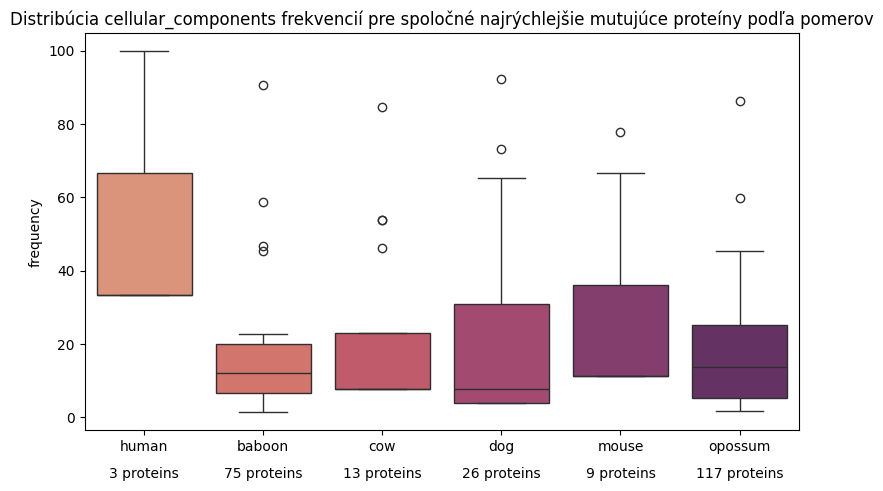

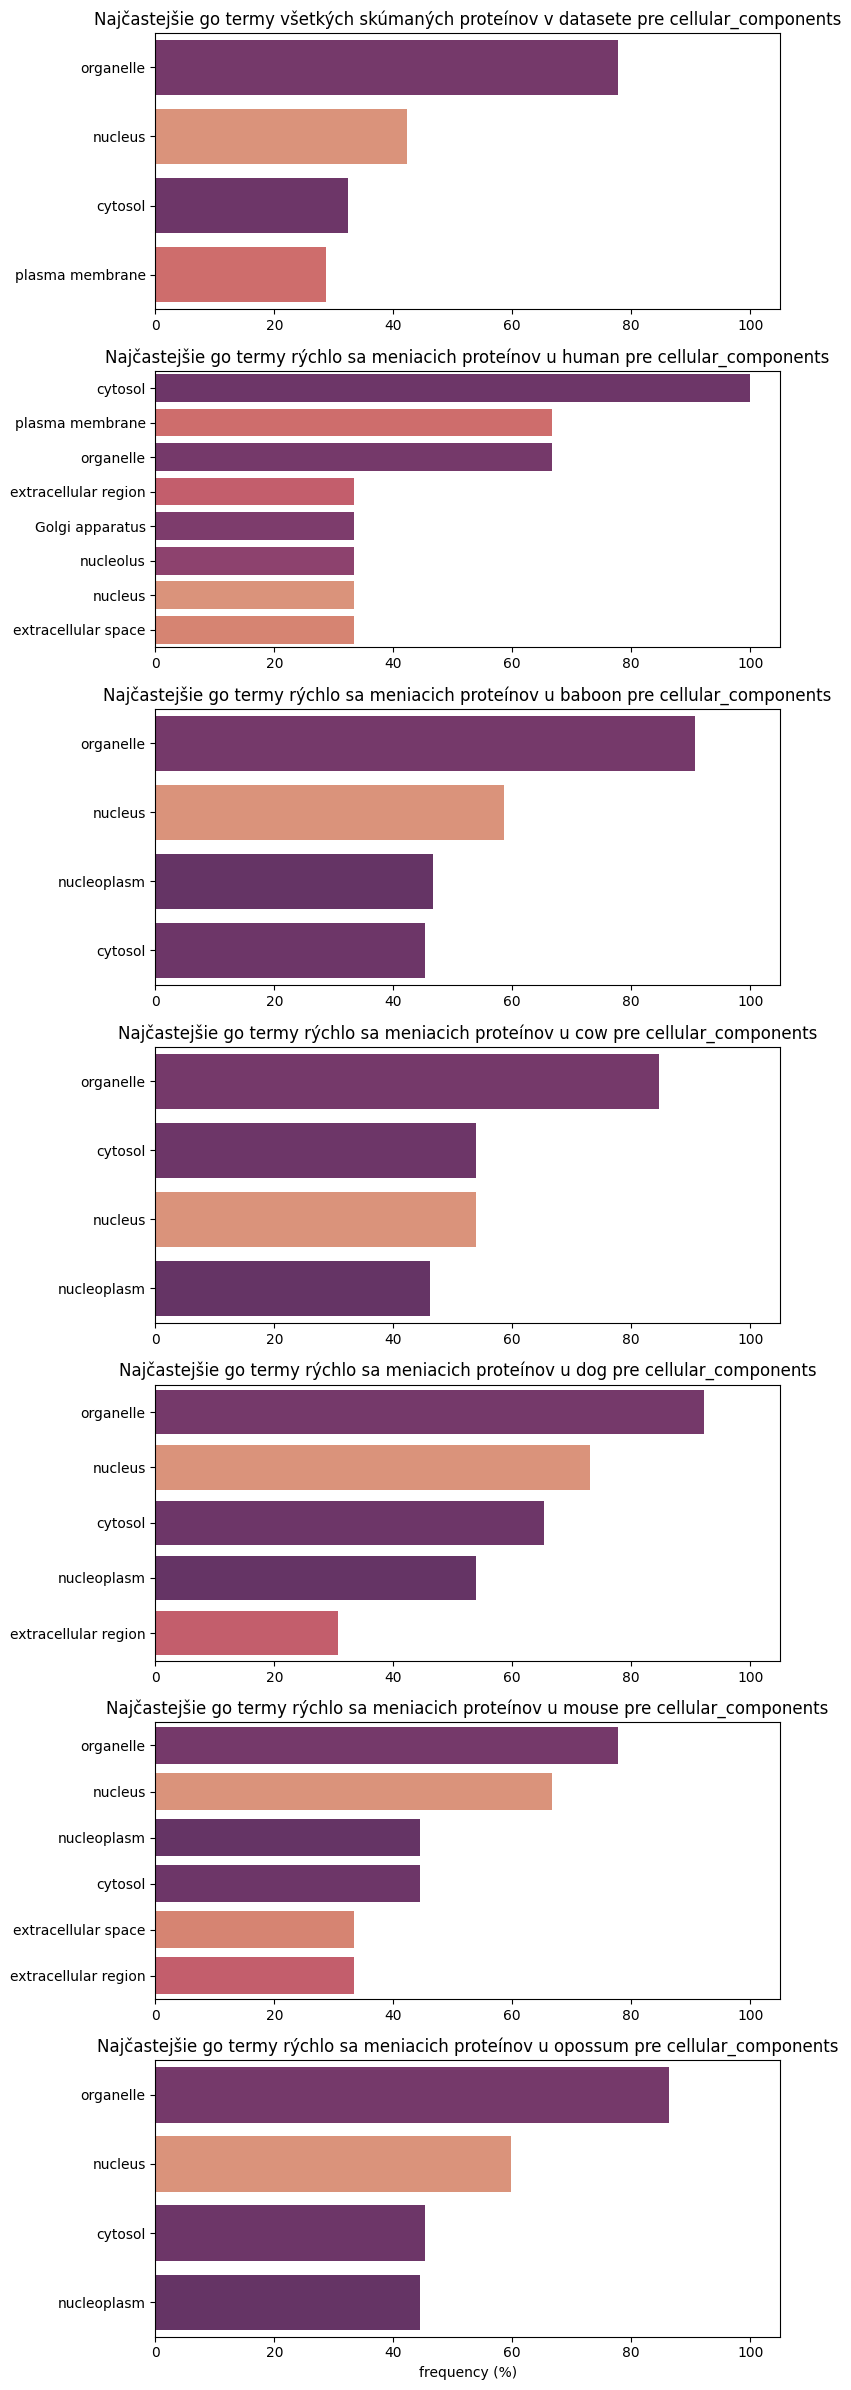

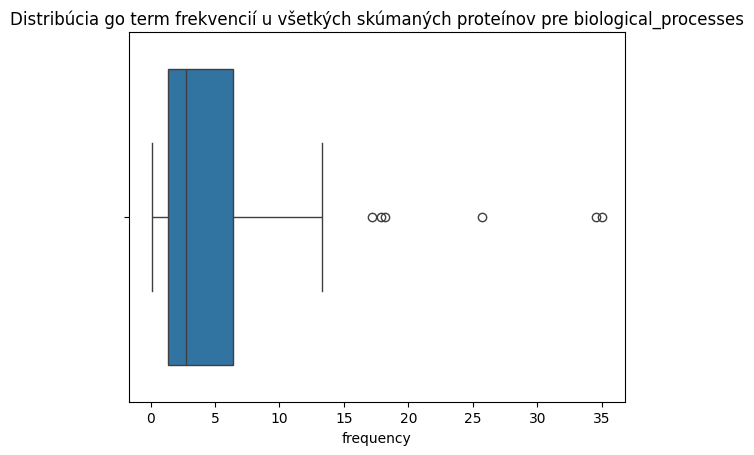

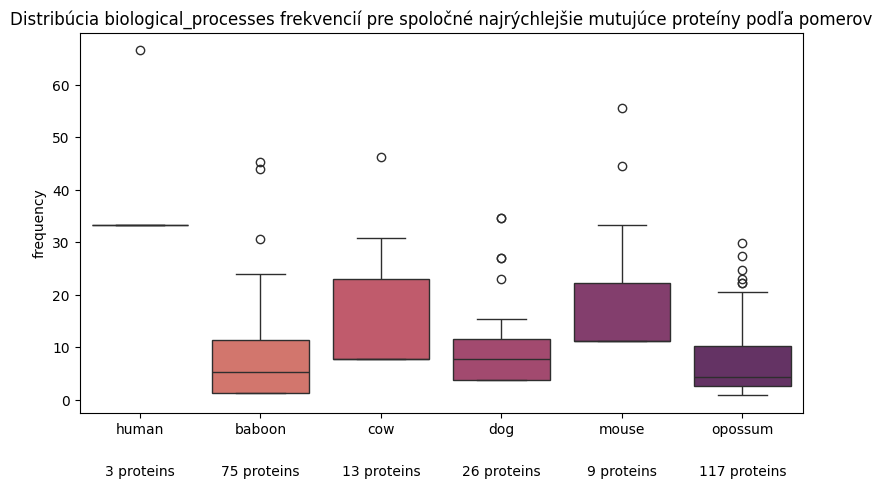

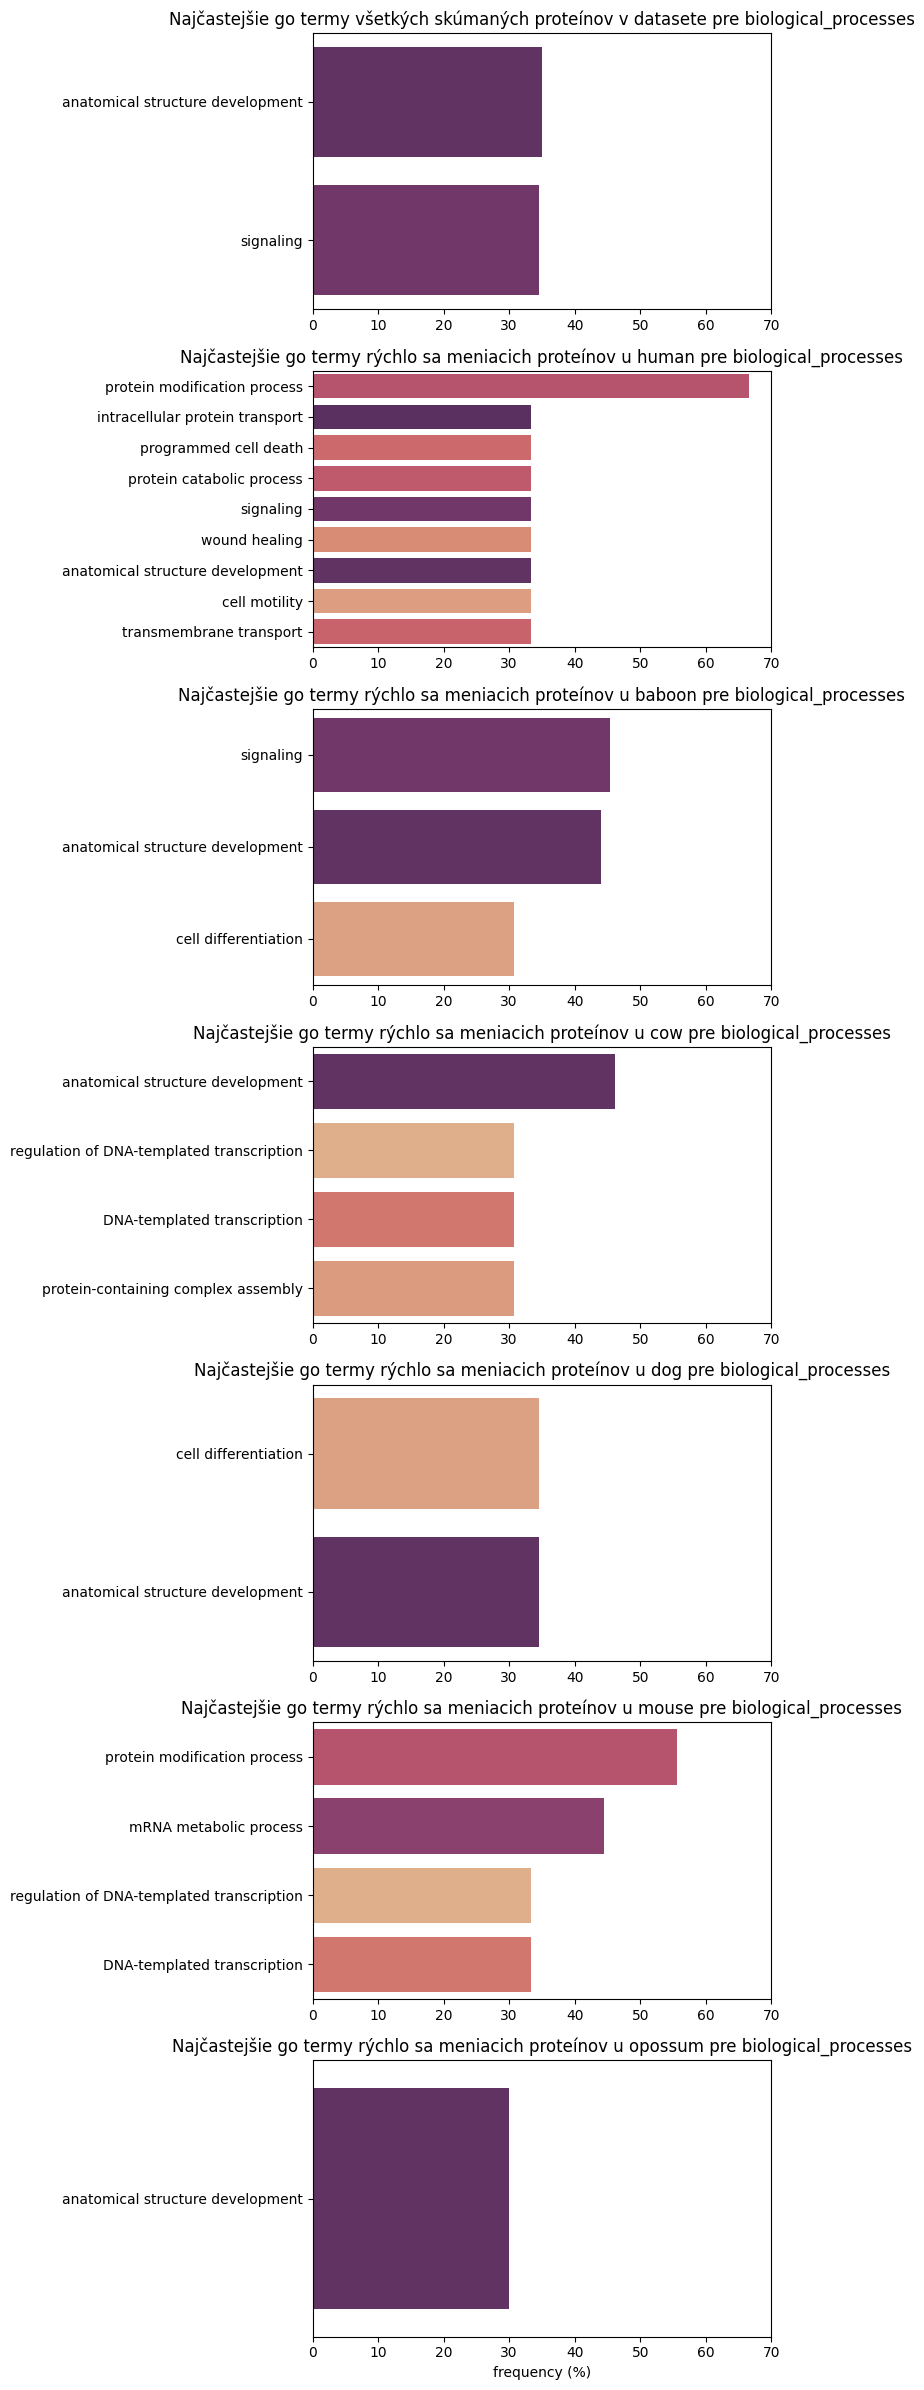

In [58]:
for cat_name, category in categories.items():
  filtered_goslim_names = goslim_names[goslim_names['name'].isin(category)]
  standard_frequency = compute_go_frequency_from_proteins(list(dist.index), goslim, filtered_goslim_names)
  sns.boxplot(x=standard_frequency['frequency'])
  plt.title(f'Distribúcia go term frekvencií u všetkých skúmaných proteínov pre {cat_name}')
  plt.show()

  species_list, all_frequencies, counts = compute_frequencies_for_all(1000,
      top_n_species_proteins, goslim, filtered_goslim_names)

  frequencies = pd.concat(all_frequencies)
  plt.figure(figsize=(8, 5))
  ax = sns.boxplot(data=frequencies, x='species', y='frequency', hue='species', palette='flare')

  for tick, species in enumerate(ax.get_xticklabels()):
    name = species.get_text()
    n = counts[tick]
    ax.text(tick, ax.get_ylim()[0] - 10, f'{n} proteins',
            ha='center', va='top', fontsize=10, color='black')
  plt.title(f'Distribúcia {cat_name} frekvencií pre spoločné najrýchlejšie mutujúce proteíny podľa pomerov')
  plt.xlabel('')
  plt.tight_layout()
  plt.show()

  fig, axes = plt.subplots(len(species_list) + 1, 1, figsize=(8, 4 * len(species_list)),
                          sharex=True)

  all_functions = set(standard_frequency['go_term'])
  for df in all_frequencies:
      all_functions.update(df['go_term'].unique())
  function_palette = sns.color_palette("flare", n_colors=len(all_functions))
  color_dict = {func: color for func, color in zip(list(all_functions), function_palette)}

  if cat_name == 'molecular_functions':
    cutoff = 20
  else:
    cutoff = 27.5

  frequency_barplot([standard_frequency], 0, None, axes[0], cutoff, cat_name, color_dict)

  for i, (species, ax) in enumerate(zip(species_list, axes[1:])):
    frequency_barplot(all_frequencies, i, species, ax, cutoff, cat_name, color_dict)

  plt.tight_layout()
  plt.show()

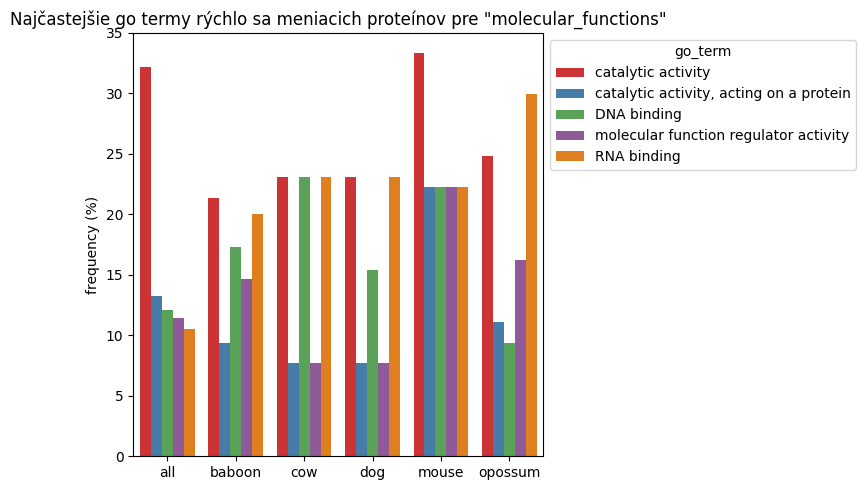

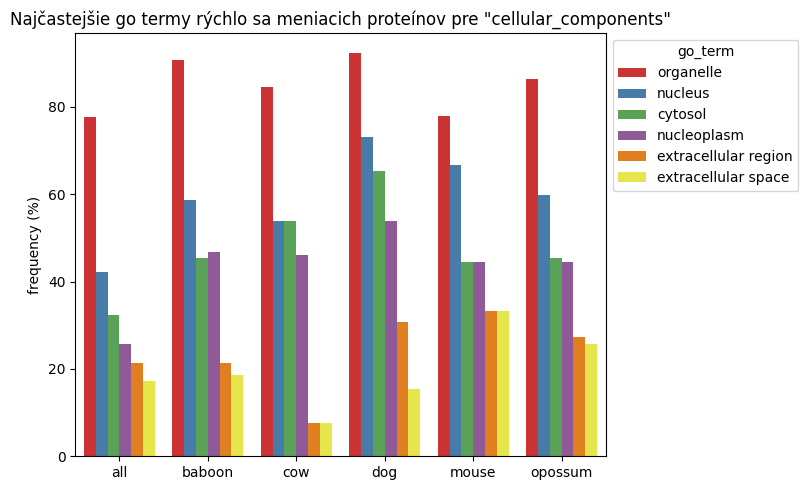

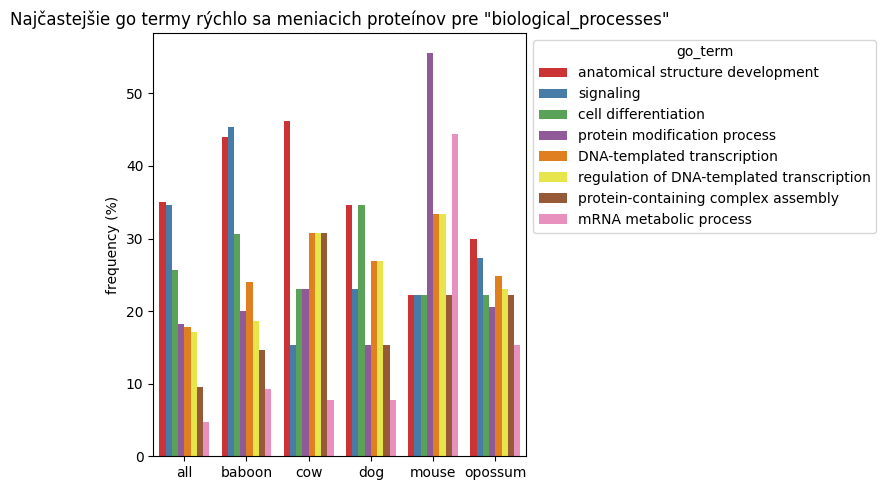

In [63]:
ylims = {'molecular_functions': None,
         'cellular_components': 140,
         'biological_processes': 100}

for cat_name, category in categories.items():
  filtered_goslim_names = goslim_names[goslim_names['name'].isin(category)]
  standard_frequency = compute_go_frequency_from_proteins(list(dist.index), goslim, filtered_goslim_names)

  species_list, all_frequencies, counts = compute_frequencies_for_all(1000,
      top_n_species_proteins, goslim, filtered_goslim_names)
  standard_frequency['species'] = 'all'
  all_frequencies.insert(0, standard_frequency)
  frequencies = pd.concat(all_frequencies).query("species != 'human'")

  if cat_name == 'molecular_functions':
    filtered_frequencies = frequencies.query("frequency >= 20")
  else:
    filtered_frequencies = frequencies.query("frequency >= 30")

  filtered_frequencies = set(filtered_frequencies['go_term'].unique())
  frequencies2 = frequencies.query('go_term in @filtered_frequencies')

  plt.figure(figsize=(8, 5))

  ax = sns.barplot(frequencies2, y='frequency', x='species', hue='go_term', palette='Set1',)

  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

  # plt.ylim(0, ylims[cat_name])
  plt.title(f'Najčastejšie go termy rýchlo sa meniacich proteínov pre "{cat_name}"')
  plt.ylabel('frequency (%)')
  plt.xlabel('')
  plt.tight_layout()
  plt.show()

In [64]:
display(frequencies)

occurrence  frequency                            go_term  species
go_id                                                                        
GO:0048856        4563  35.046083   anatomical structure development      all
GO:0023052        4501  34.569892                          signaling      all
GO:0030154        3346  25.698925               cell differentiation      all
GO:0036211        2367  18.179724       protein modification process      all
GO:0006351        2325  17.857143        DNA-templated transcription      all
...                ...        ...                                ...      ...
GO:0006790           1   0.854701  sulfur compound metabolic process  opossum
GO:0006954           1   0.854701              inflammatory response  opossum
GO:0032200           1   0.854701              telomere organization  opossum
GO:0007040           1   0.854701              lysosome organization  opossum
GO:0007018           1   0.854701         microtubule-based movement  opossum

[255 rows x 4 columns]

In [65]:
display(new100)

protein_id                cellular_component  \
3212      P41226                         organelle   
1918      P06493                        chromosome   
2059      P09544  external encapsulating structure   
4058      P62805               extracellular space   
11016     Q9HAF1                         nucleolus   
12178     Q9UIG0                           nucleus   
4058      P62805               extracellular space   
9097      Q96AZ6                         nucleolus   
5011      Q14839     microtubule organizing center   
12453     Q9UNH7                          endosome   
4058      P62805                        chromosome   
3992      P61586             endoplasmic reticulum   
2141      P10515                         organelle   
6127      Q5XXA6                   plasma membrane   
523       O14684             endoplasmic reticulum   
2734      P25490                         organelle   
4058      P62805              extracellular region   
4058      P62805                        chromosome   
4058      P62805               extracellular space   
11997     Q9UBN7                           nucleus   
4058      P62805                         organelle   
4058      P62805              extracellular region   
2859      P29474                          endosome   
5140      Q15366               extracellular space   
4058      P62805                           nucleus   
9952      Q99801                        chromosome   
4058      P62805                           nucleus   
4058      P62805               extracellular space   
4058      P62805                       nucleoplasm   
9965      Q99873                       nucleoplasm   
11798     Q9NZU0  external encapsulating structure   
4058      P62805                         organelle   
2926      P30989             endoplasmic reticulum   
4058      P62805              extracellular region   
1204      O75386                       nucleoplasm   
2859      P29474                           nucleus   
1921      P06727               extracellular space   
4058      P62805              extracellular region   
1985      P08100               cytoplasmic vesicle   
4058      P62805              extracellular region   
2777      P27361                         organelle   
1201      O75381                         organelle   
12522     Q9UQ03                      cytoskeleton   
2245      P12931                          endosome   
4058      P62805               extracellular space   
4058      P62805              extracellular region   
4149      P78509                   plasma membrane   
1753      P01584                          lysosome   
4058      P62805                         organelle   
2245      P12931                           vacuole   

                                   biological_process  \
3212                            immune system process   
1918                 anatomical structure development   
2059                      DNA-templated transcription   
4058                           chromatin organization   
11016                          chromatin organization   
12178       regulation of DNA-templated transcription   
4058              protein-containing complex assembly   
9097                            immune system process   
5011                                       DNA repair   
12453                 intracellular protein transport   
4058                             cell differentiation   
3992                     protein modification process   
2141   generation of precursor metabolites and energy   
6127                          transmembrane transport   
523                           lipid metabolic process   
2734                           chromatin organization   
4058              protein-containing complex assembly   
4058                           chromatin organization   
4058                           chromatin organization   
11997                            cell differentiation   
4058                            telomere organization 

In [85]:
my_dict = dict()
for _, row in standard_frequency.iterrows():
  my_dict[row['go_term']] = row['frequency']
display(my_dict)

{'anatomical structure development': 35.046082949308754,
 'signaling': 34.56989247311828,
 'cell differentiation': 25.6989247311828,
 'protein modification process': 18.17972350230415,
 'DNA-templated transcription': 17.857142857142858,
 'regulation of DNA-templated transcription': 17.18125960061444,
 'immune system process': 13.2642089093702,
 'programmed cell death': 11.658986175115208,
 'cell motility': 10.145929339477727,
 'protein-containing complex assembly': 9.539170506912441,
 'vesicle-mediated transport': 9.13978494623656,
 'cytoskeleton organization': 8.932411674347158,
 'transmembrane transport': 8.778801843317972,
 'reproductive process': 8.709677419354838,
 'cell adhesion': 8.556067588325652,
 'lipid metabolic process': 7.8878648233486945,
 'nervous system process': 6.643625192012288,
 'carbohydrate derivative metabolic process': 6.42089093701997,
 'protein catabolic process': 6.205837173579109,
 'mitotic cell cycle': 5.698924731182796,
 'intracellular protein transport': 

In [79]:
display(my_query)

occurrence  frequency                                    go_term  \
go_id                                                                          
GO:0043226         101  86.324786                                  organelle   
GO:0005634          70  59.829060                                    nucleus   
GO:0005829          53  45.299145                                    cytosol   
GO:0005654          52  44.444444                                nucleoplasm   
GO:0003723          35  29.914530                                RNA binding   
GO:0048856          35  29.914530           anatomical structure development   
GO:0005576          32  27.350427                       extracellular region   
GO:0023052          32  27.350427                                  signaling   
GO:0005615          30  25.641026                        extracellular space   
GO:0006351          29  24.786325                DNA-templated transcription   
GO:0003824          29  24.786325                         catalytic activity   
GO:0005886          28  23.931624                            plasma membrane   
GO:0006355          27  23.076923  regulation of DNA-templated transcription   
GO:0065003          26  22.222222        protein-containing complex assembly   
GO:0030154          26  22.222222                       cell differentiation   
GO:0036211          24  20.512821               protein modification process   

            species  
go_id                
GO:0043226  opossum  
GO:0005634  opossum  
GO:0005829  opossum  
GO:0005654  opossum  
GO:0003723  opossum  
GO:0048856  opossum  
GO:0005576  opossum  
GO:0023052  opossum  
GO:0005615  opossum  
GO:0006351  opossum  
GO:0003824  opossum  
GO:0005886  opossum  
GO:0006355  opossum  
GO:0065003  opossum  
GO:0030154  opossum  
GO:0036211  opossum

In [105]:
frequencies_combined = pd.DataFrame()
for cat_name, category in categories.items():
  frequencies1 = frequencies
  filtered_goslim_names = goslim_names[goslim_names['name'].isin(category)]
  standard_frequency = compute_go_frequency_from_proteins(list(dist.index), goslim, filtered_goslim_names)

  species_list, all_frequencies, counts = compute_frequencies_for_all(1000,
      top_n_species_proteins, goslim, filtered_goslim_names)
  standard_frequency['species'] = 'all'
  all_frequencies.insert(0, standard_frequency)
  frequencies = pd.concat(all_frequencies).query("species != 'human'")
  frequencies_combined = pd.concat([frequencies_combined, frequencies], ignore_index=True)

all_combined = (frequencies_combined[frequencies_combined['species']=='all'])
display(all_combined)

occurrence  frequency                                  go_term species
0          4191  32.188940                       catalytic activity     all
1          1791  13.755760                       hydrolase activity     all
2          1741  13.371736                     transferase activity     all
3          1730  13.287250  catalytic activity, acting on a protein     all
4          1573  12.081413                              DNA binding     all
..          ...        ...                                      ...     ...
304          76   0.583717                        endocrine process     all
305          54   0.414747                  snRNA metabolic process     all
306          39   0.299539               respiratory system process     all
307          33   0.253456                  peroxisome organization     all
308          10   0.076805         nitrogen cycle metabolic process     all

[134 rows x 4 columns]

In [106]:
my_dict = dict()
for _, row in all_combined.iterrows():
  my_dict[row['go_term']] = row['frequency']
display(my_dict)

{'catalytic activity': 32.18894009216589,
 'hydrolase activity': 13.755760368663594,
 'transferase activity': 13.37173579109063,
 'catalytic activity, acting on a protein': 13.287250384024576,
 'DNA binding': 12.081413210445469,
 'molecular function regulator activity': 11.405529953917052,
 'RNA binding': 10.514592933947773,
 'transcription regulator activity': 8.847926267281107,
 'transporter activity': 7.081413210445469,
 'molecular transducer activity': 6.190476190476191,
 'cytoskeletal protein binding': 6.082949308755761,
 'lipid binding': 4.961597542242703,
 'oxidoreductase activity': 4.039938556067589,
 'structural molecule activity': 4.009216589861751,
 'molecular adaptor activity': 3.771121351766513,
 'ATP-dependent activity': 3.4485407066052227,
 'receptor ligand activity': 2.5192012288786483,
 'catalytic activity, acting on RNA': 2.488479262672811,
 'GTPase activity': 1.7972350230414749,
 'catalytic activity, acting on DNA': 1.6359447004608296,
 'histone binding': 1.382488479

In [114]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_hex
edges = []

for _, row in new100.iterrows():
    cc1 = row['cellular_component']
    mf1 = row['molecular_functions']
    bp1 = row['biological_process']

    if pd.notna(cc1) and pd.notna(mf1):
        cc1_str = str(cc1).strip()
        mf1_str = str(mf1).strip()
        edge = (((cc1_str, mf1_str)))
        edges.append(edge)

    if pd.notna(mf1) and pd.notna(bp1):
        mf1_str = str(mf1).strip()
        bp1_str = str(bp1).strip()
        edge = tuple(((mf1_str, bp1_str)))
        edges.append(edge)

    if pd.notna(cc1) and pd.notna(bp1):
        mf1_str = str(cc1).strip()
        bp1_str = str(bp1).strip()
        edge = tuple(((cc1_str, bp1_str)))
        edges.append(edge)

edge_weights = Counter(edges)

pyvis_net = Network("800px", "800px", notebook=True, cdn_resources='in_line')
pyvis_net.from_nx(G)

neighbors = pyvis_net.get_adj_list()

values = list(my_dict.values())
vmin = min(values)
vmax = np.percentile(values, 90)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('Blues')

for node in pyvis_net.nodes:
    node_id = node["id"]
    node["title"] = node_id
    node["value"] = len(neighbors[node_id])
    node["label"] = node_id

    color = to_hex(cmap(norm(my_dict[node_id])))
    node["color"] = color

for edge in pyvis_net.edges:
    edge_pair = tuple(((edge['from'], edge['to'])))
    edge['width'] = edge_weights.get(edge_pair, 1)
pyvis_net.show_buttons(filter_=['nodes', 'edges', 'physics', 'layout'])

pyvis_net.force_atlas_2based()
pyvis_net.show_buttons(filter_=['physics'])
pyvis_net.show("net2.html")
display(HTML("net2.html"))

net2.html


<ipython-input-114-12487b609be3>:39: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

